# 导入包 & 读数据

In [3]:
import pandas as pd
import numpy as np
from astropy.io import fits,ascii
from astropy.table import Table
import astropy.units as u

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches4
from matplotlib import colors
import matplotlib.patches as mpatches

import scipy.constants as C
import scipy.interpolate as spi

from itertools import product

import warnings
from scipy.signal import find_peaks

from scipy import integrate
from scipy.optimize import curve_fit

# from plotbin.display_pixels import display_pixels

import glob
from time import perf_counter as clock
from os import path
# import ppxf as ppxf_package
# from ppxf.ppxf import ppxf
# import ppxf.ppxf_util as util

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.max_open_warning']=30

In [4]:
### 读数据
sdssj0228 = fits.open("data/SDSSJ022849.51-090153.8.fits",memmap = True)
spec_data = sdssj0228[1].data
spec_var  = sdssj0228[2].data
min_wave  = sdssj0228[0].header['WAVELMIN']*10
max_wave  = sdssj0228[0].header['WAVELMAX']*10
wave_len  = np.linspace(min_wave,max_wave,spec_data.shape[0])
wavelength = wave_len/(1+0.072)
mask_pp   = (wavelength > 4800) & (wavelength < 7409)

ppdata = fits.open("data/ppxf/SDSSJ0228_mask_ppxf_fitdata.fits")
pp_galaxy = ppdata[4].data
pp_bestfit = ppdata[2].data
pp_wave = ppdata[1].data["wavelength"]

In [5]:
wave_len

array([4600.02636719, 4601.27636719, 4602.52636719, ..., 9347.52636719,
       9348.77636719, 9350.02636719])

In [6]:
np.diff(wave_len)

array([1.25, 1.25, 1.25, ..., 1.25, 1.25, 1.25])

# White image

In [73]:
from astropy import wcs
from astropy.wcs import WCS
import matplotlib.patches as patches

In [74]:
header_0228 = sdssj0228[1].header
wcs1 = WCS(header_0228)

wcs_new = wcs.WCS(naxis=2)
wcs_new.wcs.crpix = [159,156]
wcs_new.wcs.crval = np.array([37.206292,-9.03161])
wcs_new.wcs.cdelt = np.array([-5.55555555555556e-05, 5.55555555555556e-05]) #minus for left-east
wcs_new.wcs.ctype = ['RA---TAN', 'DEC--TAN']

wcs_new.pixel_to_world(142+25,162+25)

<SkyCoord (ICRS): (ra, dec) in deg
    (37.20578573, -9.02983222)>

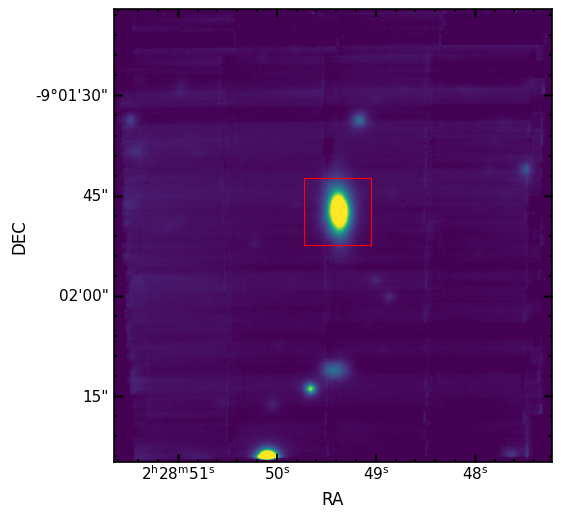

In [925]:
fig = plt.figure(figsize = (6,6),dpi=100)
ax = fig.add_subplot(111, projection=wcs_new)
ax.set_xlabel('RA',fontsize = 12)
ax.set_ylabel('DEC',fontsize = 12)
ax.tick_params(direction='in', labelsize = 11, length = 6, width=1.2)

image_wihte = np.nansum(spec_data,axis=0)
ax.imshow(image_wihte, origin='lower', cmap=plt.cm.viridis,vmin=100,vmax=110000)

# rect0 = patches.Rectangle((142, 165),50,40,linewidth=0.8,edgecolor='darkorange',facecolor='none')
# ax.add_patch(rect0)

rect1 = patches.Rectangle((142, 162),50,50,linewidth=0.8,edgecolor='red',facecolor='none')
ax.add_patch(rect1)

# plt.savefig('J0228_whiteimg.pdf',dpi=600,bbox_inches='tight')

# fake rband img & WCS校正

In [352]:
import pyphot
from pyphot import Filter
from pyphot import (unit, Filter)
import pandas as pd
### 自定义filter
legacy_r = pd.read_csv("legacy/CTIO_DECam.r.dat", sep = " ", header=None,names=["wavelength","fraction"])
lwr = np.array(legacy_r["wavelength"])
ltr = np.array(legacy_r["fraction"])
legacy_rband = Filter(lwr, ltr, name='legacy_rband', dtype='photon', unit='Angstrom')

legacy_g = pd.read_csv("legacy/CTIO_DECam.g.txt", sep = " ", header=None,names=["wavelength","fraction"])
lwg = np.array(legacy_g["wavelength"])
ltg = np.array(legacy_g["fraction"])
legacy_gband = Filter(lwg, ltg, name='legacy_gband', dtype='photon', unit='Angstrom')

legacy_i = pd.read_csv("legacy/CTIO_DECam.i.txt", sep = " ", header=None,names=["wavelength","fraction"])
lwi = np.array(legacy_i["wavelength"])
lti = np.array(legacy_i["fraction"])
legacy_iband = Filter(lwi, lti, name='legacy_iband', dtype='photon', unit='Angstrom')

In [358]:
### 读数据
wavelength  = wave_len * unit['AA']
mr_spec = np.zeros(shape = (spec_d.shape[1],spec_d.shape[2]))
mg_spec = np.zeros(shape = (spec_d.shape[1],spec_d.shape[2]))
mi_spec = np.zeros(shape = (spec_d.shape[1],spec_d.shape[2]))

for i in range(spec_d.shape[2]):
    for j in range(spec_d.shape[1]):
        flux_n = np.array(spec_d[:,j,i] * unit['erg/s/cm**2/AA'])
        flux_rband = legacy_rband.get_flux(wavelength, flux_n)   ##rband
        flux_gband = legacy_gband.get_flux(wavelength, flux_n)   ##gband
        flux_iband = legacy_iband.get_flux(wavelength, flux_n)   ##iband
        mr_spec[j][i] = flux_rband
        mg_spec[j][i] = flux_gband
        mi_spec[j][i] = flux_iband

In [449]:
def update_wcs(head):
     coord_str = head['RA']+' '+head['DEC']
     coord_deg = pyasl.coordsSexaToDeg(coord_str)

     w           = wcs.WCS(naxis=2)
     w.wcs.crpix = [13, 19]               #xcen, ycen
     w.wcs.crval = np.array(coord_deg)    #
     w.wcs.cdelt = np.array([-1.0/3600.0, 1.0/3600.0]) #minus for left-east
     w.wcs.ctype = ['RA---TAN', 'DEC--TAN']

     new_head    = w.to_header()
     #new_head.append('OBJECT', head['OBJECT'])
     #new_head.append('EXPTIME', head['EXPTIME'])
     #w = wcs.WCS(new_head)
     #print(w.wcs.naxis)


     head.update(new_head)

     return head

In [622]:
data_new = np.array(mr_spec)
col = j0228_pip[1].header
hdu = fits.PrimaryHDU(data_new, header = col)
hdulist = fits.HDUList([hdu])
hdulist.writeto('J0228_rband_img.fits',overwrite = True )
hdulist.close()

# 连续谱拟合

## SF region spec chk


In [249]:
bpt_type_data = fits.open("data/SDSSJ0228_BPT_type.fits")
bpt_type = bpt_type_data[1].data
SF =4

In [262]:
y0,x0 = 162, 142
pix   = 0
spec_SF = np.full_like(spec_data[:,187,167],0)
var_SF  = np.full_like(spec_data[:,187,167],0)
for y in np.arange(50):
    for x in np.arange(50):
        if bpt_type[y,x] == SF:
            spec_SF += spec_data[:,y0+y,x0+x]
            var_SF  += spec_var[:,y0+y,x0+x]
            pix     += 1

In [276]:
z_fix=0.072
degree=-1
plot=False
formal_error=False
ppxf_dir = path.dirname(path.realpath(ppxf_package.__file__))

### ??muse????
#     file = "data/SDSSJ022849.51-090153.8_DATACUBE_FINAL_2019-10-20T08.23.58.345.fits"   
hdu = sdssj0228
t = spec_SF/pix
z = 0   # redshift 

min_wave = hdu[0].header['WAVELMIN']*10
max_wave = hdu[0].header['WAVELMAX']*10
wave_len = np.linspace(min_wave,max_wave,hdu[1].data.shape[0])
wavelength = wave_len/(1+z_fix)

### ??stellar library ??galaxy ??????????????

mask = (wavelength > 4800) & (wavelength < 7409)

flux = t[mask]
galaxy = flux/np.median(flux)   
lam_gal = wavelength[mask]
noise = np.sqrt(np.abs(var_SF)[mask])       
c = 299792.458                  
frac = lam_gal[1]/lam_gal[0]    
fwhm = np.full_like(wavelength, 2.42, dtype=np.double)
fwhm_gal = fwhm[mask]           
velscale = np.log(frac)*c       


#######################################################????#########################################################################

vazdekis = glob.glob(ppxf_dir + '/miles_models/Mun1.30Z*.fits')
fwhm_tem = 2.51 # Vazdekis+10 spectra have a constant resolution FWHM of 2.51A.
hdu = fits.open(vazdekis[0])
ssp = hdu[0].data
h2 = hdu[0].header
lam_temp = h2['CRVAL1'] + h2['CDELT1']*np.arange(h2['NAXIS1'])
lamRange_temp = [np.min(lam_temp), np.max(lam_temp)]
sspNew = util.log_rebin(lamRange_temp, ssp, velscale=velscale)[0]
templates = np.empty((sspNew.size, len(vazdekis)))
fwhm_gal = np.interp(lam_temp, lam_gal, fwhm_gal)

fwhm_dif = np.sqrt((fwhm_gal**2 - fwhm_tem**2).clip(0))
sigma = fwhm_dif/2.355/h2['CDELT1'] # Sigma difference in pixels

for j, fname in enumerate(vazdekis):
    hdu = fits.open(fname)
    ssp = hdu[0].data
    ssp = util.gaussian_filter1d(ssp, sigma)  # perform convolution with variable sigma
    sspNew = util.log_rebin(lamRange_temp, ssp, velscale=velscale)[0]
    templates[:, j] = sspNew/np.median(sspNew) # Normalizes templates

c = 299792.458   # km/s
dv = c*np.log(lam_temp[0]/lam_gal[0])  # eq.(8) of Cappellari (2017)
goodpixels = util.determine_goodpixels(np.log(lam_gal), lamRange_temp, z)

vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
start = [vel, 100.]  # (km/s), starting guess for [V, sigma]
t = clock()

pp = ppxf(templates, galaxy, noise, velscale, start,
          goodpixels=goodpixels, plot=plot, moments=4,
          degree=degree, vsyst=dv, clean=False, lam=lam_gal)

if formal_error:
    print("Formal errors:")
    print("     dV    dsigma   dh3      dh4")
    print("".join("%8.2g" % f for f in pp.error*np.sqrt(pp.chi2)))


    print('Elapsed time in PPXF: %.2f s' % (clock() - t))

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:         0       100     0.000     0.000
chi2/DOF: 8.161e-05; degree = -1; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 16; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150


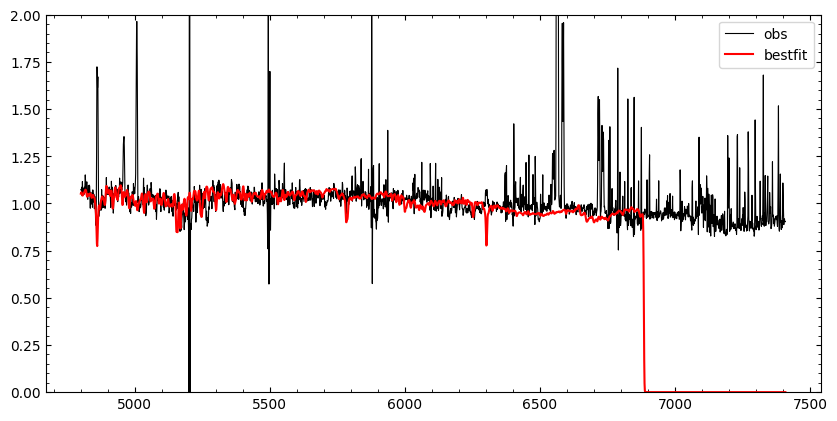

In [277]:
plt.figure(figsize=(10,5),dpi = 100)
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True

ax = plt.subplot(111)
ax.plot(lam_gal,pp.galaxy,'k',lw=0.8,label = "obs")
ax.plot(lam_gal,pp.bestfit,'r',label = "bestfit")
# plt.xlim(4600,6900)
plt.ylim(0,2)

plt.legend()

## ppxf fit batch

In [436]:
#### ppxf 拟合连续谱的函数
def single_pixel_ppxf_fit(y,x,degree,plot,formal_error,z_fix):
    ppxf_dir = path.dirname(path.realpath(ppxf_package.__file__))

    ### ??muse????
#     file = "data/SDSSJ022849.51-090153.8_DATACUBE_FINAL_2019-10-20T08.23.58.345.fits"   
    hdu = sdssj0228
    t = hdu[1].data[:,y,x]
    z = 0   # redshift 

    min_wave = hdu[0].header['WAVELMIN']*10
    max_wave = hdu[0].header['WAVELMAX']*10
    wave_len = np.linspace(min_wave,max_wave,hdu[1].data.shape[0])
    wavelength = wave_len/(1+z_fix)

    ### ??stellar library ??galaxy ??????????????

    mask = (wavelength > 4800) & (wavelength < 7409)

    flux = t[mask]
    galaxy = flux/np.median(flux)   
    lam_gal = wavelength[mask]
    noise = np.sqrt(hdu[2].data[:,y,x][mask])       
    c = 299792.458                  
    frac = lam_gal[1]/lam_gal[0]    
    fwhm = np.full_like(wavelength, 2.42, dtype=np.double)
    fwhm_gal = fwhm[mask]           
    velscale = np.log(frac)*c       


    #######################################################????#########################################################################

    vazdekis = glob.glob(ppxf_dir + '/miles_models/Mun1.30Z*.fits')
    fwhm_tem = 2.51 # Vazdekis+10 spectra have a constant resolution FWHM of 2.51A.
    hdu = fits.open(vazdekis[0])
    ssp = hdu[0].data
    h2 = hdu[0].header
    lam_temp = h2['CRVAL1'] + h2['CDELT1']*np.arange(h2['NAXIS1'])
    lamRange_temp = [np.min(lam_temp), np.max(lam_temp)]
    sspNew = util.log_rebin(lamRange_temp, ssp, velscale=velscale)[0]
    templates = np.empty((sspNew.size, len(vazdekis)))
    fwhm_gal = np.interp(lam_temp, lam_gal, fwhm_gal)

    fwhm_dif = np.sqrt((fwhm_gal**2 - fwhm_tem**2).clip(0))
    sigma = fwhm_dif/2.355/h2['CDELT1'] # Sigma difference in pixels

    for j, fname in enumerate(vazdekis):
        hdu = fits.open(fname)
        ssp = hdu[0].data
        ssp = util.gaussian_filter1d(ssp, sigma)  # perform convolution with variable sigma
        sspNew = util.log_rebin(lamRange_temp, ssp, velscale=velscale)[0]
        templates[:, j] = sspNew/np.median(sspNew) # Normalizes templates

    c = 299792.458   # km/s
    dv = c*np.log(lam_temp[0]/lam_gal[0])  # eq.(8) of Cappellari (2017)
    goodpixels = util.determine_goodpixels(np.log(lam_gal), lamRange_temp, z)

    vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
    start = [vel, 100.]  # (km/s), starting guess for [V, sigma]
    t = clock()

    pp = ppxf(templates, galaxy, noise, velscale, start,
              goodpixels=goodpixels, plot=plot, moments=4,
              degree=degree, vsyst=dv, clean=False, lam=lam_gal)
    
    if formal_error:
        print("Formal errors:")
        print("     dV    dsigma   dh3      dh4")
        print("".join("%8.2g" % f for f in pp.error*np.sqrt(pp.chi2)))


        print('Elapsed time in PPXF: %.2f s' % (clock() - t))
        
    return pp

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:         0       100     0.000     0.000
chi2/DOF: 0.0002084; degree = 4; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 15; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  0 / 150


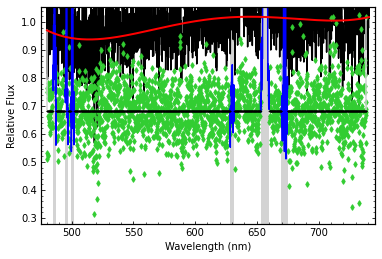

In [437]:
pp_test = single_pixel_ppxf_fit(188,169,z_fix=0.072,degree=4,plot=True,formal_error=False)

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     20843       100     0.000     0.000
chi2/DOF: 2.447e-18; degree = 4; mdegree = 0
method = capfit; Jac calls: 1; Func calls: 7; Status: 3
linear_method = lsq_box; Nonzero Templates (>0.1%):  1 / 150
Formal errors:
     dV    dsigma   dh3      dh4
   2e+02 2.4e+02     1.2     1.2
Elapsed time in PPXF: 0.11 s


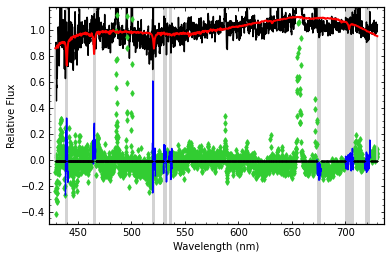

In [660]:
## 2x2 spaxel test
ppxf_dir = path.dirname(path.realpath(ppxf_package.__file__))

### ??muse????
#     file = "data/SDSSJ022849.51-090153.8_DATACUBE_FINAL_2019-10-20T08.23.58.345.fits"   
z       = 0.072
file    = 'data/SDSSJ0228_spec_resample_region_select.fits'
hdu     = fits.open(file)
data    = hdu[0].data
data_var= hdu[1].data
head    = hdu[0].header
wave    = 10**( head['CRVAL3'] + np.arange(head['NAXIS3'])*head['CD3_3'] )    
wavelength = wave/(1+z)

jj,ii = 12,12
t        = data[:,jj,ii]*10**18
var      = data_var[:,jj,ii]*10**18
err      = np.sqrt(np.abs(var))*10**18

### ??stellar library ??galaxy ??????????????
mask = (wavelength > 3600) & (wavelength < 7300)

flux = t[mask]
galaxy = flux/np.median(flux)   
lam_gal = wavelength[mask]
noise = err[mask]      
c = 299792.458                  
frac = lam_gal[1]/lam_gal[0]    
fwhm = np.full_like(wavelength, 2.42, dtype=np.double)
fwhm_gal = fwhm[mask]           
velscale = np.log(frac)*c       


#######################################################????#########################################################################

vazdekis = glob.glob(ppxf_dir + '/miles_models/Mun1.30Z*.fits')
fwhm_tem = 2.51 # Vazdekis+10 spectra have a constant resolution FWHM of 2.51A.
hdu = fits.open(vazdekis[0])
ssp = hdu[0].data
h2 = hdu[0].header
lam_temp = h2['CRVAL1'] + h2['CDELT1']*np.arange(h2['NAXIS1'])
lamRange_temp = [np.min(lam_temp), np.max(lam_temp)]
sspNew = util.log_rebin(lamRange_temp, ssp, velscale=velscale)[0]
templates = np.empty((sspNew.size, len(vazdekis)))
fwhm_gal = np.interp(lam_temp, lam_gal, fwhm_gal)

fwhm_dif = np.sqrt((fwhm_gal**2 - fwhm_tem**2).clip(0))
sigma = fwhm_dif/2.355/h2['CDELT1'] # Sigma difference in pixels

for j, fname in enumerate(vazdekis):
    hdu = fits.open(fname)
    ssp = hdu[0].data
    ssp = util.gaussian_filter1d(ssp, sigma)  # perform convolution with variable sigma
    sspNew = util.log_rebin(lamRange_temp, ssp, velscale=velscale)[0]
    templates[:, j] = sspNew/np.median(sspNew) # Normalizes templates

c = 299792.458   # km/s
dv = c*np.log(lam_temp[0]/lam_gal[0])  # eq.(8) of Cappellari (2017)
goodpixels = util.determine_goodpixels(np.log(lam_gal), lamRange_temp, z)

vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
start = [vel, 100.]  # (km/s), starting guess for [V, sigma]
t = clock()

pp = ppxf(templates, galaxy, noise, velscale, start,
          goodpixels=goodpixels, plot=True, moments=4,
          degree=4, vsyst=dv, clean=False, lam=lam_gal)

print("Formal errors:")
print("     dV    dsigma   dh3      dh4")
print("".join("%8.2g" % f for f in pp.error*np.sqrt(pp.chi2)))
print('Elapsed time in PPXF: %.2f s' % (clock() - t))
        

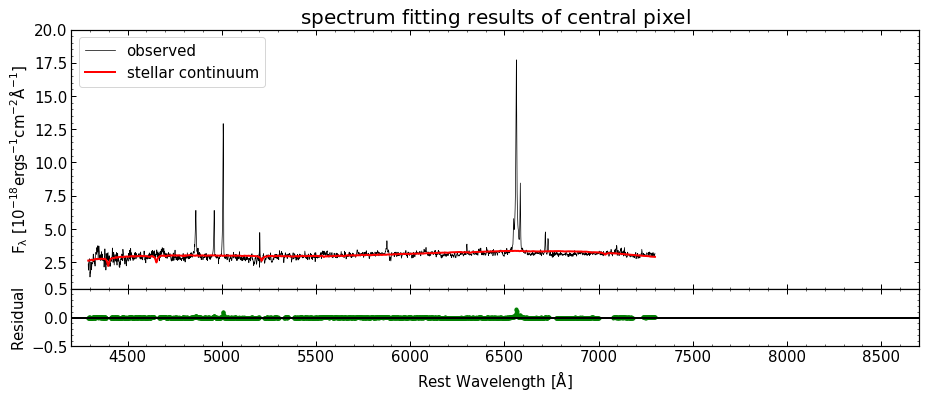

In [661]:
fig = plt.figure(figsize= (15,8))

plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True

ax_ppxf = plt.axes([.143, .50, .785, .45])
ax_ppxf.set_xticklabels([])
ax_resid = plt.axes([.143,.40,.785,.10])

mask_pp = (wavelength > 3600) & (wavelength < 8700)
con_bestfit = pp.bestfit*np.median(flux)
ax_ppxf.plot(lam_gal,flux,'k',lw=0.7,label='observed')
ax_ppxf.plot(lam_gal,con_bestfit,'r',lw=2,label='stellar continuum')


ax_ppxf.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
ax_ppxf.set_ylabel(r'${\rm F_{\lambda}\ [10^{-18}ergs^{-1}cm^{-2}\AA^{-1}]}$',fontsize=15)
ax_ppxf.set_title(r'${\rm spectrum\ fitting\ results\ of\ central\ pixel}$',fontsize=20)
ax_ppxf.set_ylim(0.5,20)
ax_ppxf.set_xlim(4200,8700)

residual_con = (pp.galaxy-pp.bestfit)*np.median(flux)
ax_resid.plot(wavelength[mask_pp][pp.goodpixels],residual_con[pp.goodpixels]*10**(-2),'g.',label='residual')
ax_resid.plot([4200,8700],[0,0],color = "black",linewidth=2)
ax_resid.set_xlim(4200,8700)
ax_resid.set_ylim(-0.5,0.5)
ax_resid.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
ax_resid.set_xlabel(r'${\rm Rest\ Wavelength\ [\AA]}$',fontsize=15)
ax_resid.set_ylabel(r'${\rm Residual}$',fontsize=15)
ax_ppxf.legend(loc='upper left',fontsize = 15.0,markerscale = 2)

# 光谱拟合结果图

In [12]:
from pkg.MUSE_data_reduce import spec_fit
rebin_data_Ha = fits.open('analyse_data_image/SDSSJ0228/SDSSJ0228_rebin_specHa_10.fits')
ppdata = fits.open("ppxf/SDSSJ0228/SDSSJ0228_mask_ppxf_fitdata.fits")
pp_wave = ppdata[1].data["wavelength"]

{'Hb[4861]_para': array([5.78874162e+01, 4.86216479e+03, 1.83286846e+00]),
 'Hb[4861]_broad_para': array([  49.62195133, 4859.70802369,    5.        ]),
 'Hb[4861]_perr': array([16.63730174,  0.41262819,  0.54747643]),
 'Hb[4861]_broad_perr': array([15.05303675,  1.09982034,  0.79495969]),
 'fit_Chi2': 60.8271744110389,
 'fit_rChi2': 1.3517149869119756}

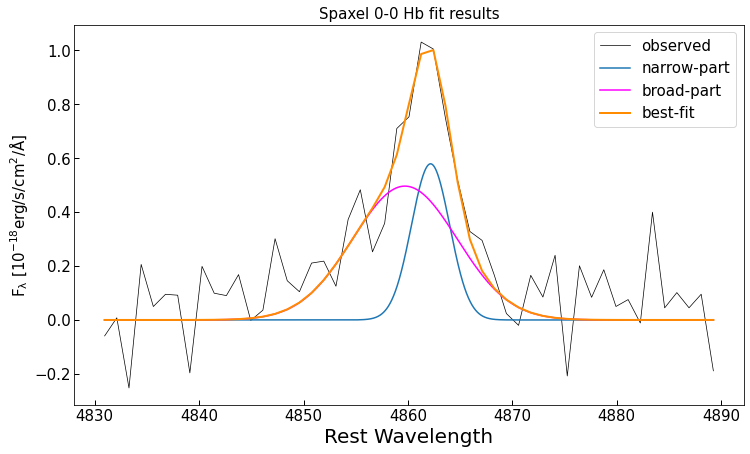

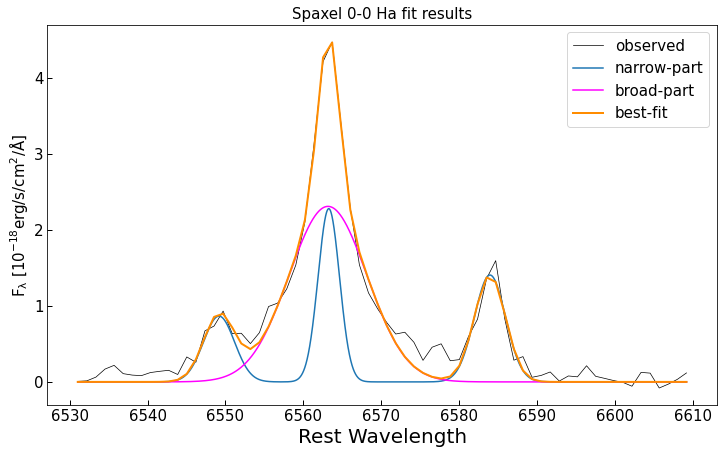

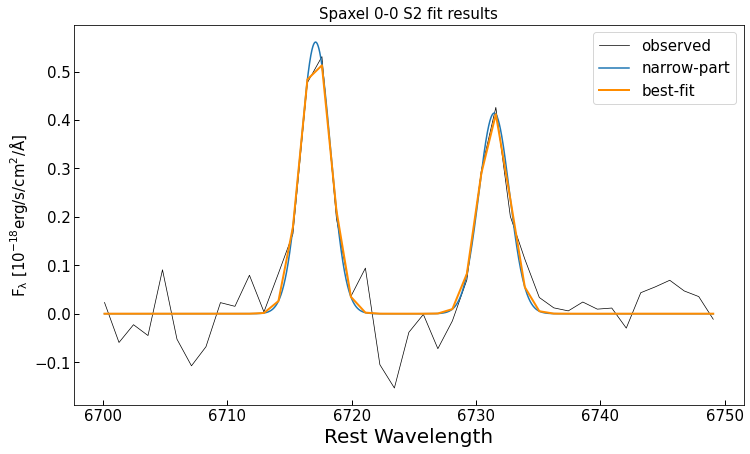

In [18]:
y,x =24,25
spec_flux = rebin_data_Ha[1].data[:,y,x]
spec_err = rebin_data_Ha[2].data[:,y,x]
spec_con = rebin_data_Ha[3].data[:,y,x]
STATUS_hb,KINEM_hb = spec_fit.emline_fit(pp_wave,spec_flux,spec_err,spec_con,mode ='Hb')
STATUS_ha,KINEM_ha = spec_fit.emline_fit(pp_wave,spec_flux,spec_err,spec_con,mode ='Ha')
STATUS_S2,KINEM_S2 = spec_fit.emline_fit(pp_wave,spec_flux,spec_err,spec_con,mode ='S2')
STATUS_hb

<ipython-input-475-dca1aba6ca11>:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


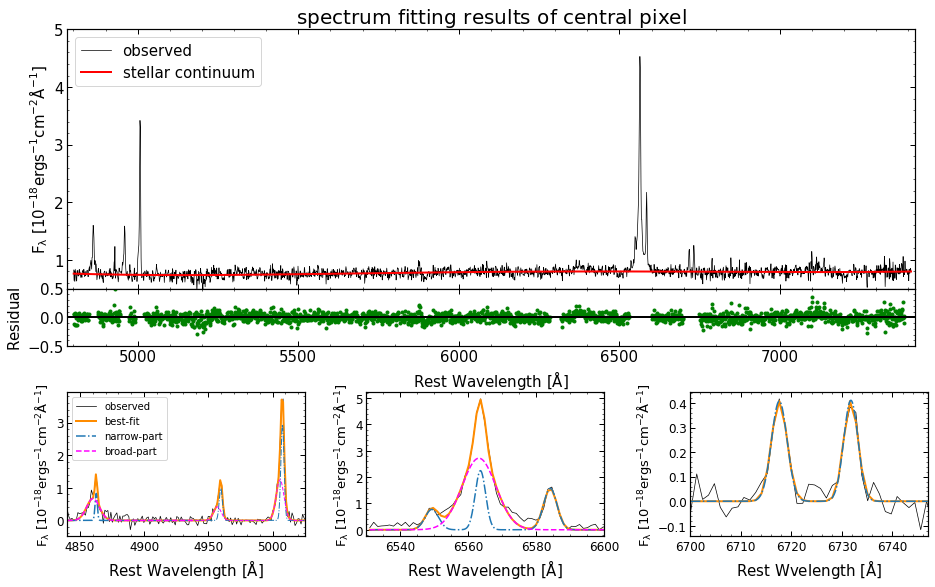

In [475]:
fig = plt.figure(figsize= (15,8))

plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True

ax_ppxf = plt.axes([.143, .50, .785, .45])
ax_ppxf.set_xticklabels([])
ax_resid = plt.axes([.143,.40,.785,.10])
ax_hb = plt.axes([.143, .07, .22, .25])
ax_ha = plt.axes([.420, .07, .22, .25])
ax_s2 = plt.axes([.720, .07, .22, .25])

####################################################    stellar continuum    ###############################################################
mask_pp = (wavelength > 4800) & (wavelength < 7409)
con_bestfit = pp_test.bestfit*np.median(spec_data[:,188,169][mask_pp])
ax_ppxf.plot(wavelength[mask_pp],spec_data[:,188,169][mask_pp]*10**(-2),'k',lw=0.7,label='observed')
ax_ppxf.plot(wavelength[mask_pp],con_bestfit*10**(-2),'r',lw=2,label='stellar continuum')
# ax_ppxf.plot(wavelength[mask_pp],(spec_data[:,188,169][mask_pp]-con_bestfit)*10**(-2),'gray',lw=0.7,label='continuum-subtracted')


ax_ppxf.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
ax_ppxf.set_ylabel(r'${\rm F_{\lambda}\ [10^{-18}ergs^{-1}cm^{-2}\AA^{-1}]}$',fontsize=15)
ax_ppxf.set_title(r'${\rm spectrum\ fitting\ results\ of\ central\ pixel}$',fontsize=20)
ax_ppxf.set_ylim(0.5,5)
ax_ppxf.set_xlim(4780,7420)

residual_con = (pp_test.galaxy-pp_test.bestfit)*np.median(spec_data[:,188,169][mask_pp])
ax_resid.plot(wavelength[mask_pp][pp_test.goodpixels],residual_con[pp_test.goodpixels]*10**(-2),'g.',label='residual')
ax_resid.plot([4780,7420],[0,0],color = "black",linewidth=2)
ax_resid.set_xlim(4780,7420)
ax_resid.set_ylim(-0.5,0.5)
ax_resid.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
ax_resid.set_xlabel(r'${\rm Rest\ Wavelength\ [\AA]}$',fontsize=15)
ax_resid.set_ylabel(r'${\rm Residual}$',fontsize=15)
ax_ppxf.legend(loc='upper left',fontsize = 15.0,markerscale = 2)

################################################    Hb 4861 [OIII] 4959,5007    ############################################################
maskhb  = (pp_wave > 4830) & (pp_wave < 5030)
mask_HB = (pp_wave > 4830) & (pp_wave < 4941)
mask_Hb = (pp_wave > 4830) & (pp_wave < 4890)
fithb_wave = pp_wave[mask_Hb]
fitHB_wave = pp_wave[mask_HB]
fithb_spec = spec_flux[mask_HB]
popt_hb = np.array(list(STATUS_hb['Hb[4861]_para'])+list(STATUS_hb['Hb[4861]_broad_para']))
fakehb_x = np.arange(fitHB_wave[0], fitHB_wave[-1], 0.01)

ax_hb.plot(pp_wave[maskhb], spec_flux[maskhb] * 10 ** (-2), color='k', lw=0.7, alpha=1, label='observed')
ax_hb.plot(fitHB_wave, spec_fit.gaussian(fitHB_wave, *popt_hb) * 10 ** (-2), color='darkorange', lw=2, label='best-fit')
ax_hb.plot(fakehb_x, spec_fit.gaussian(fakehb_x, *popt_hb[0:3]) * 10 ** (-2),'-.', color='C0', label='narrow-part')
try:
    ax_hb.plot(fakehb_x, spec_fit.gaussian(fakehb_x, *popt_hb[3:6]) * 10 ** (-2),'--', label='broad-part', color='magenta')
except:
    pass

mask_OIII = ((pp_wave > 4940) & (pp_wave < 5030))
fitOIII_wave = pp_wave[mask_OIII]
poptOIII = np.array(STATUSo3['fit_parameter'])
fakeO3_x = np.arange(4940,5030,0.01)

ax_hb.plot(fitOIII_wave,gauss_doublet(fitOIII_wave,*poptOIII)*10**(-2),color='darkorange',lw=2)
ax_hb.plot(fakeO3_x,gauss_doublet(fakeO3_x,*poptOIII[0:4])*10**(-2),'-.',color='C0',lw=1)
try:
    ax_hb.plot(fakeO3_x,gauss_doublet(fakeO3_x,*poptOIII[4:8])*10**(-2),'--',color='magenta',lw=1)
except:
    pass

ax_hb.set_xlabel(r'${\rm Rest\ Wavelength\ [\AA]}$',fontsize=15)
ax_hb.tick_params(direction='in', labelsize = 12, length = 5, width=1.0)
ax_hb.set_ylabel(r'${\rm F_{\lambda}\ [10^{-18}ergs^{-1}cm^{-2}\AA^{-1}]}$',fontsize=13)
ax_hb.set_xlim(4840,5025)
ax_hb.legend(loc='upper left')

################################################    Ha 6563 [NII] 6548,6583    ############################################################

mask_Ha = ((pp_wave > 6530) & (pp_wave < 6610))
fitha_wave = pp_wave[mask_Ha]
fitha_spec = spec_flux[mask_Ha]
popt_ha = np.array(list(STATUS_ha['NII[6548]_para'])+list(STATUS_ha['Ha[6563]_para'])+
                   list(STATUS_ha['NII[6583]_para'])+list(STATUS_ha['Ha[6563]_broad_para']))
fakeha_x = np.arange(fitha_wave[0], fitha_wave[-1], 0.01)

ax_ha.plot(fitha_wave, fitha_spec * 10 ** (-2), color='k', lw=0.7, alpha=1,)
ax_ha.plot(fitha_wave, spec_fit.gaussian(fitha_wave, *popt_ha) * 10 ** (-2), color='darkorange', lw=2,)
ax_ha.plot(fakeha_x, spec_fit.gaussian(fakeha_x, *popt_ha[0:9]) * 10 ** (-2),'-.', color='C0',)
try:
    ax_ha.plot(fakeha_x, spec_fit.gaussian(fakeha_x, *popt_ha[9:12]) * 10 ** (-2),'--', color='magenta')
except:
    pass

ax_ha.set_xlim(6530,6600)
ax_ha.set_xlabel(r'${\rm Rest\ Wavelength\ [\AA]}$',fontsize=15)
ax_ha.tick_params(direction='in', labelsize = 12, length = 5, width=1.0)
ax_ha.set_ylabel(r'${\rm F_{\lambda}\ [10^{-18}ergs^{-1}cm^{-2}\AA^{-1}]}$',fontsize=13)

#######################################################    [SII] 6717,6731    ############################################################

mask_SII = ((pp_wave > 6700) & (pp_wave < 6750))
fits2_wave = pp_wave[mask_SII]
fits2_spec = spec_flux[mask_SII]
popt_s2 = np.array(list(STATUS_S2['SII[6717]_para'])+list(STATUS_S2['SII[6731]_para']))
fakes2_x = np.arange(fits2_wave[0], fits2_wave[-1], 0.01)

ax_s2.plot(fits2_wave, fits2_spec * 10 ** (-2), color='k', lw=0.7, alpha=1,)
ax_s2.plot(fits2_wave, spec_fit.gaussian(fits2_wave, *popt_s2) * 10 ** (-2), color='darkorange', lw=2,)
ax_s2.plot(fakes2_x, spec_fit.gaussian(fakes2_x, *popt_s2) * 10 ** (-2),'-.', color='C0',)

ax_s2.set_xlim(6700,6747)
# ax_s2.set_ylim(-0.2,0.6)
ax_s2.tick_params(direction='in', labelsize = 12, length = 5, width=1.0)
ax_s2.set_xlabel(r'${\rm Rest\ Wvelength\ [\AA]}$',fontsize=15)
ax_s2.set_ylabel(r'${\rm F_{\lambda}\ [10^{-18}ergs^{-1}cm^{-2}\AA^{-1}]}$',fontsize=13)
plt.tight_layout()
plt.savefig('spectrum_fit_results.pdf',dpi = 600,bbox_inches='tight')

# Hb

In [3]:
from pkg import spec_fit
rebin_data_Ha = fits.open('data/SDSSJ0228_rebin_specHa_10.fits')
ppdata = fits.open("data/ppxf/SDSSJ0228_mask_ppxf_fitdata.fits")
pp_wave = ppdata[1].data["wavelength"]

spec_flux = rebin_data_Ha[1].data
spec_err = rebin_data_Ha[2].data
spec_con = rebin_data_Ha[3].data

In [8]:
Hb_ew = np.zeros((50,50))
Hb_ew_b = np.zeros((50,50))
for y in range(50):
    for x in range(50):
        STATUS_hb,KINEM_hb = spec_fit.emline_fit(pp_wave,spec_flux[:,y,x],spec_err[:,y,x],spec_con[:,y,x],
                                                 mode ='Hb',plot = False)
        Hb_ew[y,x] = KINEM_hb["Hb[4861]_EW"]
        try:
            Hb_ew_b[y,x] = KINEM_hb["Hb[4861]_broad_EW"]
        except:
            Hb_ew_b[y,x] = 0

({'Hb[4861]_para': array([8.54149279e+01, 4.86259462e+03, 9.36268478e-01]),
  'Hb[4861]_broad_para': array([  61.7801403 , 4860.12084835,    5.57666569]),
  'Hb[4861]_perr': array([16.54088911,  0.19490503,  0.20278511]),
  'Hb[4861]_broad_perr': array([7.39058338, 0.60593544, 0.55448126]),
  'fit_Chi2': 76.37707740690391,
  'fit_rChi2': 1.6972683868200868},
 {'Hb[4861]_flux': 200.45833310116814,
  'Hb[4861]_broad_flux': 863.6015933072491,
  'Hb[4861]_fluxerr': 44.067439398529935,
  'Hb[4861]_broad_fluxerr': 94.31982498366469,
  'Hb[4861]_velocity': nan,
  'Hb[4861]_broad_velocity': nan,
  'Hb[4861]_EW': 2.2201136612019607,
  'Hb[4861]_broad_EW': 9.564549726997758})

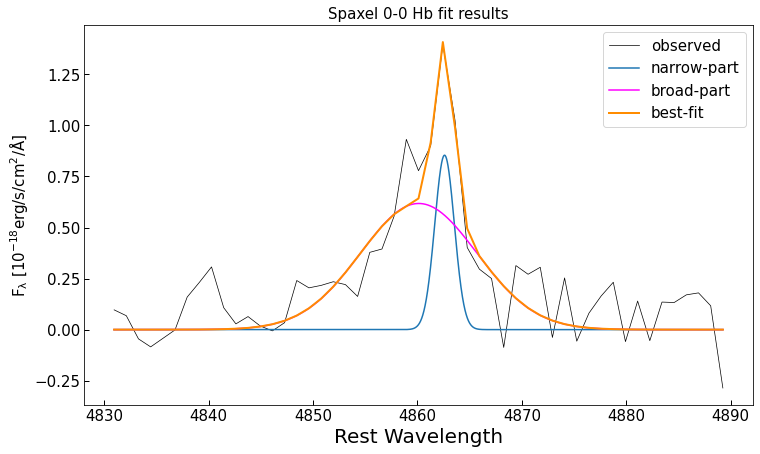

In [5]:
spec_fit.emline_fit(pp_wave,spec_flux[:,25,25],spec_err[:,25,25],spec_con[:,25,25],mode ='Hb')

# Photon-ionized model-[OIII]

## emline fit batch

In [309]:
def gauss_doublet(x,*p):
    f = np.zeros_like(x)
    for i in np.arange(0,np.asarray(p).shape[0],4):
        f_O3b = p[i]
        f_O3a = f_O3b/3
        mean_a = p[i+1]
        mean_b = p[i+2]
        sigma_a = p[i+3]
        sigma_b = sigma_a 
        f+= ((f_O3a/(sigma_a*np.sqrt(2*np.pi))) * np.exp(-0.5*((x-mean_a)/sigma_a)**2)+
             (f_O3b/(sigma_b*np.sqrt(2*np.pi))) * np.exp(-0.5*((x-mean_b)/sigma_b)**2))
    return f 

In [310]:
def CHI2(fitwave,fitF,fitFerr,*p,fitmodel):
    
    CHI2 = np.sum(((fitF-fitmodel(fitwave,*p))/fitFerr)**2)
    rCHI2 = CHI2/(fitwave.shape[0]-np.asarray(p).shape[0])
    
    return CHI2,rCHI2

In [311]:
def gas_kine(p,perr):
    
    p = np.asarray(p)
    perr = np.asarray(perr)
    p_err = np.sqrt(np.diag(perr))
    OIII_xc = 5006.84
    
    if p.shape[0] == 4:
        O3b_flux = p[0]
        O3b_flux_err = p_err[0]
        O3a_flux = O3b_flux/3
        O3a_flux_err = O3b_flux_err/3
        O3a_mean = p[1]
        O3b_mean = p[2]
        O3b_sigma = O3a_sigma = p[3]
        
        v_narrow = ((O3b_mean-OIII_xc)/OIII_xc)*3*10**5/0.8718
        
        line_name = ['[OIII]4959_flux','[OIII]4959_flux_err',
                     '[OIII]5007_flux','[OIII]5007_flux_err',
                     '[OIII]5007_v']
        gas_kin = [O3a_flux,O3a_flux_err,O3b_flux,O3b_flux_err,v_narrow]
        
        
    else:
        O3b_flux = p[0]
        O3b_flux_err = p_err[0]
        O3a_flux = O3b_flux/3
        O3a_flux_err = O3b_flux_err/3
        O3a_mean = p[1]
        O3b_mean = p[2]
        O3b_sigma = O3a_sigma = p[3]
        
        O3b_flux_o = p[4]
        O3b_flux_o_err = p_err[4]
        O3a_flux_o = O3b_flux_o/3
        O3a_flux_o_err = O3b_flux_o_err/3
        O3a_mean_o = p[5]
        O3b_mean_o = p[6]
        O3b_sigma_o = O3a_sigma_o = p[7]
        
        v_narrow = (((O3b_mean-OIII_xc)/OIII_xc)*3*10**5)/0.8718
        v_broad = (((O3b_mean_o-OIII_xc)/OIII_xc)*3*10**5)/0.8718
        fwhm = 2.355*O3b_sigma_o
        W80 = 1.09 * (fwhm/OIII_xc)*3*10**5
        v_0 = v_broad-v_narrow
        v_outf = -v_0+(W80/2)
        
        line_name = ['[OIII]4959_flux','[OIII]4959_flux_err',
                     '[OIII]5007_flux','[OIII]5007_flux_err',
                     '[OIII]5007_v',
                     '[OIII]4959_broad_flux','[OIII]4959_broad_flux_err',
                     '[OIII]5007_broad_flux','[OIII]5007_broad_flux_err',
                     '[OIII]5007_broad_v','[OIII]5007_broad_W80',
                     '[OIII]5007_broad_vout',]
        gas_kin = [O3a_flux,O3a_flux_err,O3b_flux,O3b_flux_err,v_narrow,
                  O3a_flux_o,O3a_flux_o_err,O3b_flux_o,O3b_flux_o_err,v_broad,W80,v_outf]
    
    gas_kinemics = dict(zip(line_name,gas_kin))
    
    return gas_kinemics

In [312]:
def O3_doublet_fit(wave,spec_flux,spec_error,plot,savefig):
    
    galaxy_wave = wave
    galaxy_flux = spec_flux
    galaxy_err = spec_error
    
    mask_OIII = ((galaxy_wave > 4940) & (galaxy_wave < 5030))
    fitOIII_wave = galaxy_wave[mask_OIII]
    fitOIII_flux = galaxy_flux[mask_OIII]
    fitOIII_err = galaxy_err[mask_OIII]

    mask_O3a = ((galaxy_wave > 4950) & (galaxy_wave < 4970))
    mask_O3b = ((galaxy_wave > 4997) & (galaxy_wave < 5017))
    flux_iO3b = np.abs(np.sum(galaxy_flux[mask_O3b])) 
    flux_iO3a = flux_iO3b/3
    
    
    #####  doublet  without outflow
    p_O3n = np.array([flux_iO3b,4959.,5007.,1.])
    p_O3n_bounds =([-flux_iO3b,4954.,5004.,0.],
                    [flux_iO3b,4964.,5010.,2.])
    
    poptO3n,pcovO3n = curve_fit(gauss_doublet,fitOIII_wave,fitOIII_flux,
                                      p0=p_O3n,bounds=p_O3n_bounds,
                                      sigma=fitOIII_err, absolute_sigma=True,
                                      maxfev=100000)
    chi2_n,rchi2_n = CHI2(fitOIII_wave,fitOIII_flux,fitOIII_err,*poptO3n,fitmodel=gauss_doublet)
    
    #####  doublet  with  outflow
    p_O3o = np.array([flux_iO3b,4959.,5007.,1.,
                       flux_iO3b,4959.,5007.,3.])
    p_O3o_bounds =([-flux_iO3b,4954.,5004.,0.,-flux_iO3b,4954.,5004.,2.],
                    [flux_iO3b,4964.,5010.,2., flux_iO3b,4964.,5010.,5.])
    
    poptO3o,pcovO3o = curve_fit(gauss_doublet,fitOIII_wave,fitOIII_flux,
                                      p0=p_O3o,bounds=p_O3o_bounds,
                                      sigma=fitOIII_err, absolute_sigma=True,
                                      maxfev=100000)
    chi2_o,rchi2_o = CHI2(fitOIII_wave,fitOIII_flux,fitOIII_err,*poptO3o,fitmodel=gauss_doublet)
    
    if chi2_n-chi2_o >17:
        poptOIII = poptO3o
        pcovOIII = pcovO3o
        chi2 = chi2_o
        rchi2 = rchi2_o
    else:
        poptOIII = poptO3n
        pcovOIII = pcovO3n
        chi2 = chi2_n
        rchi2 = rchi2_n
        
    gas_kinemics = gas_kine(poptOIII,pcovOIII)
    status_name = ["fit_parameter","para_error","CHI2","rCHI2"]
    status = [poptOIII,np.sqrt(np.diag(pcovOIII)),chi2,rchi2]
    fit_status = dict(zip(status_name,status))
        
    
    if plot:
        fig = plt.figure(figsize=(10,6))
        fake_hbx = np.arange(4940,5030,0.01)

        ax1 = fig.add_subplot(111)
        ax1.plot(fitOIII_wave,gauss_doublet(fitOIII_wave,*poptOIII)*10**(-2),color='darkorange',lw=2,label='best-fit')
        ax1.plot(fitOIII_wave,fitOIII_flux*10**(-2),color='k', lw=0.7, alpha=1,label='observed')
        ax1.set_xlabel('Rest Wavelength')
        ax1.set_ylabel(r'${\rm Flux\ [10^{-18}erg/s/cm^2/\AA]}$')
        plt.legend()

        ax1.plot(fake_hbx,gauss_doublet(fake_hbx,*poptOIII[0:4])*10**(-2),label='narrow-part',color='C0',lw=1)
        try:
            ax1.plot(fake_hbx,gauss_doublet(fake_hbx,*poptOIII[4:8])*10**(-2),label='broad-part',color='magenta',lw=1)
        except:
            pass

        plt.legend()
        plt.show()
         
        if savefig:
            plt.savefig('O3_doublet_fit.pdf',dpi = 600)
    return fit_status,gas_kinemics

In [34]:
y,x = 25,25
O3_doublet_fit(pp_wave,spec_flux_rebin_Ha[:,y,x],spec_err_rebin_Ha[:,y,x],
                                  plot = 1,savefig = 0)

NameError: name 'O3_doublet_fit' is not defined

In [368]:
#### 计算
vbx = np.arange(50)
vby = np.arange(50)
O3_5007_naf    = np.zeros((50,50))
O3_5007_brf    = np.zeros((50,50))
O3_5007_naferr = np.zeros((50,50))
O3_5007_brferr = np.zeros((50,50))
O3_4959_naf    = np.zeros((50,50))
O3_4959_brf    = np.zeros((50,50))
O3_4959_naferr = np.zeros((50,50))
O3_4959_brferr = np.zeros((50,50))

velo_OIII_narrow   = np.zeros((50,50))
velo_OIII_broad_50 = np.zeros((50,50))
velo_OIII_broad_80 = np.zeros((50,50))
W80                = np.zeros((50,50))
sigma_n            = np.zeros((50,50))
sigma_n_err        =  np.zeros((50,50))
sigma_b            = np.zeros((50,50))
sigma_b_err        = np.zeros((50,50))
# of_x = []

# of_y = []
for x,y in product(vbx,vby):
    
#     if Snr_O3_n[y,x]<2 and Snr_O3_b[y,x]<2 :
        
#         flux_OIII_narrow[y,x] = np.nan
#         flux_OIII_narrow_err[y,x] = np.nan
#         velo_OIII_narrow[y,x] = np.nan
#         flux_OIII_broad[y,x]    = np.nan
#         flux_OIII_broad_err[y,x] = np.nan
#         velo_OIII_broad_50[y,x] = np.nan
#         velo_OIII_broad_80[y,x] = np.nan
        
        
        
#     else:
        
    Status,Kinem = O3_doublet_fit(pp_wave,spec_flux_rebin_Ha[:,y,x],spec_err_rebin_Ha[:,y,x],
                                  plot = 0,savefig = 0)

#     O3_5007_naf[y,x]    = Kinem.get('[OIII]5007_flux')
#     O3_5007_naferr[y,x] = Kinem.get('[OIII]5007_flux_err')
#     O3_4959_naf[y,x]    = Kinem.get('[OIII]4959_flux')
#     O3_4959_naferr[y,x] = Kinem.get('[OIII]4959_flux_err')
#     velo_OIII_narrow[y,x] = Kinem.get('[OIII]5007_v')
    sigma_n[y,x]          = Status["fit_parameter"][3]
    sigma_n_err[y,x]      = Status["para_error"][3]
    

    try:
#         O3_5007_brf[y,x]    = Kinem.get('[OIII]5007_broad_flux')
#         O3_5007_brferr[y,x] = Kinem.get('[OIII]5007_broad_flux_err')
#         O3_4959_brf[y,x]    = Kinem.get('[OIII]4959_broad_flux')
#         O3_4959_brferr[y,x] = Kinem.get('[OIII]4959_broad_flux_err')
        
#         velo_OIII_broad_50[y,x] = Kinem.get('[OIII]5007_broad_v')
#         velo_OIII_broad_80[y,x] = Kinem.get('[OIII]5007_broad_vout')
        sigma_b[y,x]            = Status["fit_parameter"][7]
        sigma_b_err[y,x]        = Status["para_error"][7]
#         W80[y,x] = Kinem.get('[OIII]5007_broad_W80')
#         of_x.append(x+142)
#         of_y.append(y+162)
    except:
#         O3_5007_brf[y,x]    = np.nan
#         O3_5007_brferr[y,x] = np.nan
#         O3_4959_brf[y,x]    = np.nan
#         O3_4959_brferr[y,x] = np.nan
#         velo_OIII_broad_80[y,x] = np.nan
#         velo_OIII_broad_50[y,x] = np.nan
        sigma_b[y,x]            = 0
        sigma_b_err[y,x]        = 0


In [318]:
###header      flux data
hdr = fits.Header()
hdr['level0'] = 'header'
hdr['level1'] = '[OIII]_4959n flux'
hdr['level2'] = '[OIII]_5007n flux'
hdr['level3'] = '[OIII]_4959n flux error'
hdr['level4'] = '[OIII]_5007n flux error'
hdr['level5'] = '[OIII]_4959b flux'
hdr['level6'] = '[OIII]_5007b flux'
hdr['level7'] = '[OIII]_4959b flux error'
hdr['level8'] = '[OIII]_5007b flux error'
hdr['object'] = 'SDSSJ0228'
hdr['redshift'] = 0.072;
hdr['fluxBUNIT'] = '10**(-20)erg.s**(-1).cm**(-2).angstrom**(-1)'
# hdr['v,sigma,W80 BUNIT'] = 'Kms**(-1)'
hdr['COMMENT'] = "photon-ionized model fit, [OIII]5007 results, flux,sigma,velocity"

empty_primary = fits.PrimaryHDU(header=hdr)

### flux, error, bestfit
image_hdu1 = fits.ImageHDU(O3_4959_naf)
image_hdu2 = fits.ImageHDU(O3_5007_naf)
image_hdu3 = fits.ImageHDU(O3_4959_naferr)
image_hdu4 = fits.ImageHDU(O3_5007_naferr)
image_hdu5 = fits.ImageHDU(O3_4959_brf)
image_hdu6 = fits.ImageHDU(O3_5007_brf)
image_hdu7 = fits.ImageHDU(O3_4959_brferr)
image_hdu8 = fits.ImageHDU(O3_5007_brferr)


hdul = fits.HDUList([empty_primary,image_hdu1,image_hdu2,image_hdu3,image_hdu4,
                     image_hdu5,image_hdu6,image_hdu7,image_hdu8,])
hdul.writeto('SDSSJ0228_O3_flux.fits', overwrite=True)

In [ ]:
###header     velocity data 
hdr = fits.Header()
hdr['level0'] = 'header'
hdr['level1'] = '[OIII]_n velocity'
hdr['level2'] = '[OIII]_b lc velocity'
hdr['level3'] = '[OIII]_b v80'
hdr['object'] = 'SDSSJ0228'
hdr['redshift'] = 0.072;
hdr['fluxBUNIT'] = '10**(-20)erg.s**(-1).cm**(-2).angstrom**(-1)'
hdr['v,sigma,W80 BUNIT'] = 'Kms**(-1)'
hdr['COMMENT'] = "photon-ionized model fit, [OIII]5007 sigma data"

empty_primary = fits.PrimaryHDU(header=hdr)

### flux, error, bestfit

image_hdu1 = fits.ImageHDU(velo_OIII_narrow)
image_hdu2 = fits.ImageHDU(velo_OIII_broad_50)
image_hdu3 = fits.ImageHDU(velo_OIII_broad_80)


hdul = fits.HDUList([empty_primary,image_hdu1,image_hdu2,image_hdu3])
hdul.writeto('SDSSJ0228_O3_5007_velocity.fits', overwrite=True)

In [369]:
###header     sigma data 
hdr = fits.Header()
hdr['level0'] = 'header'
hdr['level1'] = '[OIII]_n sigma'
hdr['level2'] = '[OIII]_n sigma error'
hdr['level3'] = '[OIII]_b sigma'
hdr['level4'] = '[OIII]_b sigma error'
hdr['object'] = 'SDSSJ0228'
hdr['redshift'] = 0.072;
hdr['fluxBUNIT'] = '10**(-20)erg.s**(-1).cm**(-2).angstrom**(-1)'
hdr['v,sigma,W80 BUNIT'] = 'Kms**(-1)'
hdr['COMMENT'] = "photon-ionized model fit, [OIII]5007 sigma data"

empty_primary = fits.PrimaryHDU(header=hdr)

### flux, error, bestfit

image_hdu1 = fits.ImageHDU(sigma_n)
image_hdu2 = fits.ImageHDU(sigma_n_err)
image_hdu3 = fits.ImageHDU(sigma_b)
image_hdu4 = fits.ImageHDU(sigma_b_err)


hdul = fits.HDUList([empty_primary,image_hdu1,image_hdu2,image_hdu3,image_hdu4])
hdul.writeto('SDSSJ0228_O3_5007_sigma.fits', overwrite=True)

## plot figure

In [510]:
o3_flux_data = fits.open('SDSSJ0228_O3_flux.fits')
o3_velo_data = fits.open('SDSSJ0228_O3_5007_kine_results.fits')

flux_OIII_narrow = o3_flux_data[2].data
flux_OIII_narrow_err = o3_flux_data[4].data
flux_OIII_broad  = o3_flux_data[6].data
flux_OIII_broad_err = o3_flux_data[8].data

velo_OIII_broad_50 = o3_velo_data[2].data
velo_OIII_broad_80 = o3_velo_data[6].data

Snr_O3_n = flux_OIII_narrow/flux_OIII_narrow_err
Snr_O3_b = flux_OIII_broad/flux_OIII_broad_err

nx = (np.arange(flux_OIII_narrow.shape[1]) - flux_OIII_narrow.shape[0]/2)/5.
ny = (np.arange(flux_OIII_narrow.shape[0]) - flux_OIII_narrow.shape[1]/2)/5.
xpos, ypos = np.meshgrid(nx, ny, sparse=False, indexing='xy')
region_selet = np.logical_and(Snr_O3_n>2,Snr_O3_b>2)

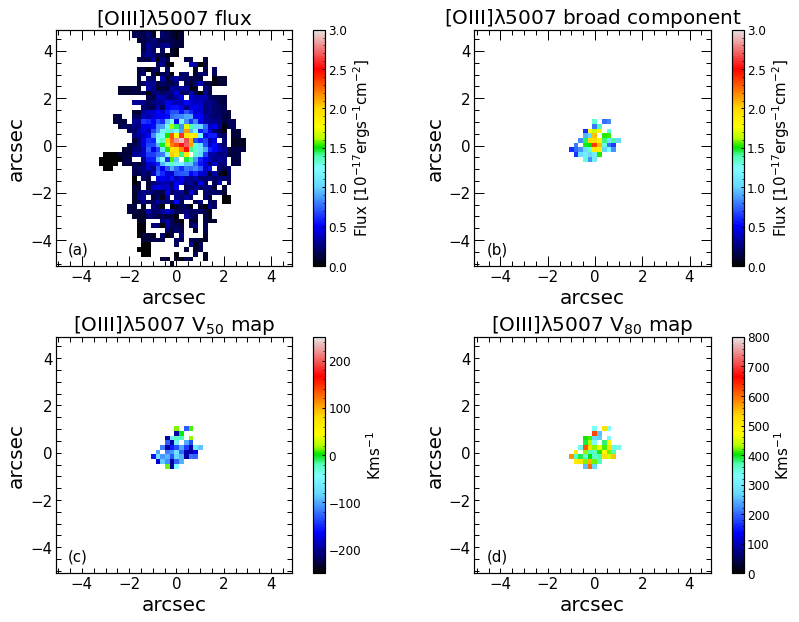

In [511]:
fig = plt.figure(figsize=(15, 10))
cmap = plt.cm.get_cmap('bwr')
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.subplots_adjust(wspace=0,hspace=0.3)

savefig = 0

ax1 = fig.add_subplot(221)
ax1.text(0.05,0.05,'(a)',transform=ax1.transAxes,fontdict={'size': '15', 'color': 'black'})
ax1.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
ax1.set_xlabel('arcsec',fontsize=20)
ax1.set_ylabel('arcsec',fontsize=20)
# ax1 = ax1.pcolormesh(ypos, xpos, flux_OIII_narrow, cmap=cmap)


narrow_snr = np.logical_not(Snr_O3_n<2)
flux_o3n = np.full_like(flux_OIII_narrow,np.nan)
flux_o3n[narrow_snr] = flux_OIII_narrow[narrow_snr]
ax1 = display_pixels(xpos, ypos, flux_o3n*10**(0.40-3),vmin=0,vmax=3)
cb = plt.colorbar(ax1)
cb.ax.tick_params(direction='in', labelsize = 12, length = 3, width=1.0)
cb.set_label(r'${\rm Flux\ [10^{-17}ergs^{-1}cm^{-2}]}$',fontsize = 15)
plt.title(r'${\rm [OIII] \lambda 5007\ flux}$',fontsize = 20)


ax2 = fig.add_subplot(222)
ax2.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
ax2.set_xlabel('arcsec',fontsize=20)
ax2.set_ylabel('arcsec',fontsize=20)
# ax2 = ax2.pcolormesh(ypos, xpos, flux_OIII_broad, cmap=cmap)
ax2.text(0.05,0.05,'(b)',transform=ax2.transAxes,fontdict={'size': '15', 'color': 'black'})

flux_o3b = np.full_like(flux_OIII_broad,np.nan)
flux_o3b[region_selet] = flux_OIII_broad[region_selet]
flux_o3b[19,24] = np.nan
ax2 = display_pixels(xpos, ypos, flux_o3b*10**(0.40-3),vmin=0,vmax=3)

cb = plt.colorbar(ax2)
cb.ax.tick_params(direction='in', labelsize = 12, length = 3, width=1.0)
cb.set_label(r'${\rm Flux\ [10^{-17}ergs^{-1}cm^{-2}]}$',fontsize = 15)
plt.title(r'${\rm [OIII] \lambda 5007\ broad\ component}$',fontsize = 20)
# plt.show()

ax3 = fig.add_subplot(223)
# velo_on_v2 = velo_on_v1 - np.median(velo_on_v1)
# ax1 = display_pixels(np.array(binxx)[region_selet],np.array(binyy)[region_selet],velo_on_v2[region_selet])
ax3.text(0.05,0.05,'(c)',transform=ax3.transAxes,fontdict={'size': '15', 'color': 'black'})
o3_v50 = np.full_like(velo_OIII_broad_50,np.nan)
o3_v50[region_selet] = velo_OIII_broad_50[region_selet]
o3_v50[19,24] = np.nan

ax3 = display_pixels(xpos, ypos, o3_v50,vmin=-250,vmax=250)

cb = plt.colorbar(ax3)
cb.ax.tick_params(direction='in', labelsize = 12, length = 3, width=1.0)
cb.set_label(r'${\rm Kms^{-1}}$',fontsize = 15)
plt.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
plt.title(r'${\rm [OIII] \lambda 5007\ V_{50}\ map}$',fontsize = 20)
plt.xlabel('arcsec',fontsize = 20)
plt.ylabel('arcsec',fontsize = 20)
# plt.ylabel('pixel_y',fontsize = 15.0)


ax4 = fig.add_subplot(224)
ax4.text(0.05,0.05,'(d)',transform=ax4.transAxes,fontdict={'size': '15', 'color': 'black'})
o3_v80 = np.full_like(velo_OIII_broad_80,np.nan)
o3_v80[region_selet] = velo_OIII_broad_80[region_selet]
o3_v80[19,24] = np.nan
ax4 = display_pixels(xpos, ypos, o3_v80,vmin=0,vmax=800)

cb = plt.colorbar(ax4)
cb.ax.tick_params(direction='in', labelsize = 12, length = 3, width=1.0)
cb.set_label(r'${\rm Kms^{-1}}$',fontsize = 15)
plt.title(r'${\rm [OIII] \lambda 5007\ V_{80}\ map}$',fontsize = 20)
plt.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
plt.xlabel('arcsec',fontsize = 20)
plt.ylabel('arcsec',fontsize = 20)

if savefig:
    plt.savefig('outflow_kine_map.pdf',dpi=600,bbox_inches='tight')

In [516]:
dist = 335.8 * 3.0856776 * 10**(24)                         ## cm
np.log10((np.nansum(flux_o3n)+np.nansum(flux_o3b))*10**(-20)*4*np.pi*dist**2 *10**0.4)  ## L[OIII]

40.69348492825357

# voronoi binning

## vorbin

In [240]:
import vorbin
from vorbin.voronoi_2d_binning import voronoi_2d_binning
from itertools import product

In [237]:
test_x = np.arange(142,192)
test_y = np.arange(162,212)
yy=[]
xx=[]
signal=[]
noise=[]
for x,y in product(test_x,test_y):
    yi,xi,si,ni,snr = signal_noise(y,x,vorbin=0,emline='O3')
    yy.append(yi)
    xx.append(xi)
    if si.size != 0:
        signal.append(si[0])
        noise.append(ni[0])
    else:
        signal.append(1)
        noise.append(5)

In [238]:
xx_v1 = np.array(xx)
yy_v1 = np.array(yy)
signal_v1 = np.array(signal)
noise_v1 = np.array(noise)

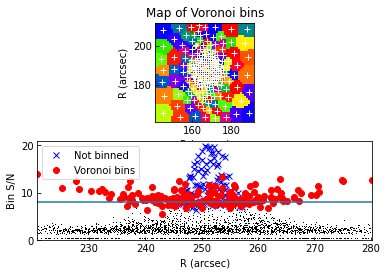

In [241]:
lname,snr_lim = 'Ha',10
binNum,xNode,yNode,xBar,yBar,sn,nPixels,scale = voronoi_2d_binning(xx_v1,yy_v1,signal_v1,noise_v1,snr_lim,plot=1,quiet=1)

/home/siro/anaconda3/lib/python3.8/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/siro/anaconda3/lib/python3.8/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


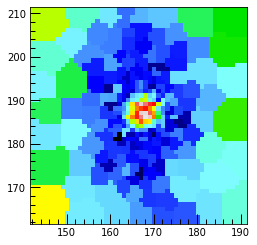

In [242]:
import plotbin
from plotbin.display_bins import display_bins
display_bins(xx_v1,yy_v1,binNum,sn)

In [1194]:
# np.savetxt('vorbin_J0228_center_'+str(lname)+'_SNR'+str(snr_lim)+'_outnput.txt', np.column_stack((xx_v1,yy_v1,binNum)),fmt='%d %d %d',header='x y binNum')

## 叠光谱

In [243]:
#### 按照binNum 讲光谱叠加取平均
center_x_new = []
center_y_new = []
stack_spec = []
stack_err = []
stack_continum = []
ccy = []
ccx = []
for i in range(binNum.max()+1):
    index_bin = np.where(binNum == i)
    index_len_i = np.array(index_bin).shape[1]
    bin_x = xx_v1[index_bin]
    bin_y = yy_v1[index_bin]
    sk_spec = []
    sk_err = []
    sk_con = []
    for k in range(index_len_i):
        cy = int(bin_y[k])
        cx = int(bin_x[k])
        pixel_spec = spec_data[:,cy,cx][mask_pp]
        pixel_err = spec_err[:,cy,cx][mask_pp]
        continum = pp_bestfit[:,cy,cx]*np.median(pixel_spec)
        spec_i = (pp_galaxy[:,cy,cx] - pp_bestfit[:,cy,cx])*np.median(pixel_spec)
        
        isnan = np.isnan(spec_i) 
        try:
            spec_i[isnan] = 0
        except:
            continue
            
        sk_spec.append(spec_i)
        sk_err.append(pixel_err)
        sk_con.append(continum)
        
        ccy.append(cy)
        ccx.append(xx)
        
    spec_sum_k = np.sum(sk_spec,axis=0)
    spec_ave_k = spec_sum_k/index_len_i
    
    spec_serr = np.sum(sk_err,axis=0)/index_len_i
    spec_error = np.sqrt(spec_serr)
    
    spec_con = np.sum(sk_con,axis=0)/index_len_i
        
    center_x_new.append(bin_x)
    center_y_new.append(bin_y)
    stack_spec.append(spec_ave_k)  
    stack_err.append(spec_error)
    stack_continum.append(spec_con)

In [244]:
### 分配平均后的光谱
stack_spec_v1 = []
stack_spec_v2 = np.zeros((2237,50,50))
stack_spec_err = np.zeros((2237,50,50))
stack_spec_con = np.zeros((2237,50,50))
for i in range(len(stack_spec)):
    bin_pxx = center_x_new[i]
    bin_pxy = center_y_new[i]
    ss_spec_i = stack_spec[i]
    ss_spec_erri = stack_err[i]
    ss_spec_coni = stack_continum[i]
    index_px = len(bin_pxx)
    for j in range(index_px):
        cy = bin_pxy[j]
        cx = bin_pxx[j]
        stack_spec_v1.append(ss_spec_i)
        stack_spec_v2[:,cy-162,cx-142] = ss_spec_i
        stack_spec_err[:,cy-162,cx-142] = ss_spec_erri
        stack_spec_con[:,cy-162,cx-142] = ss_spec_coni

In [245]:
hdr = fits.Header()
hdr['level0'] = 'header'
hdr['level1'] = 'spec_rebinned'
hdr['level1'] = 'spec_rebinned'
hdr['object'] = 'SDSS0228'
hdr['redshift'] = 0.072;
hdr['fluxBUNIT'] = '10**(-20)erg.s**(-1).cm**(-2).angstrom**(-1)'
hdr["comments"] = 'center region of galaxy, rebinned OIII snr=8,totol size 27*60,x 154-181,y 157-217 '
# hdr['COMMENT'] = "ppxf fit data(back to flux)"

empty_primary = fits.PrimaryHDU(header=hdr)
image_hdu1 = fits.ImageHDU(stack_spec_v2)
image_hdu2 = fits.ImageHDU(stack_spec_err)
image_hdu3 = fits.ImageHDU(stack_spec_con)

hdul = fits.HDUList([empty_primary,image_hdu1,image_hdu2,image_hdu3])
hdul.writeto('SDSSJ0228_rebin_spec'+str(lname)+'_'+str(snr_lim)+'.fits', overwrite=True)
# hdul.writeto('SDSSJ0228_rebinspec_box_O3_8.fits', overwrite=True)

# Ha[6563]流量、速度 map

## ha fit

In [6]:
#### 计算峰值信噪比
def signal_noise(y,x,vorbin,emline='Ha'):
    from scipy.signal import find_peaks
    wave = pp_wave
    
    if vorbin:
        speca = spec_flux_rebin_Ha[:,y,x]
        erra = spec_err_rebin_Ha[:,y,x]
        
    else:
        mask_pp = (wavelength > 4800) & (wavelength < 7409)
        speca = (pp_galaxy[:,y,x] - pp_bestfit[:,y,x])*np.median(spec_data[:,y,x][mask_pp])
        erra = np.sqrt(spec_err[:,y,x][mask_pp])
        
    if emline=='S2':
        peak_wave = 6724
        m_peak = np.where(np.abs(pp_wave-peak_wave)<14)
    elif emline=='Ha':
        peak_wave = 6562.8
        m_peak = np.where(np.abs(pp_wave-peak_wave)<10)
    elif emline=='Hb':
        peak_wave = 4861.3
        m_peak = np.where(np.abs(pp_wave-peak_wave)<10)
    elif emline=='N2':
        peak_wave = 6583.4
        m_peak = np.where(np.abs(pp_wave-peak_wave)<10)
    elif emline=='O3':
        peak_wave = 5006.8
        m_peak = np.where(np.abs(pp_wave-peak_wave)<10)
        
    

    spec_emline = speca[m_peak]
    indices = find_peaks(spec_emline, height=10,distance=15,prominence=10)

    spec_em = spec_emline[indices[0]]
    specem_err = erra[m_peak]
    err_em = specem_err[indices[0]]
        
    
    signal = spec_em
    noise = err_em
    snr = signal/noise
    
    return y,x,signal,noise,snr

In [7]:
###  计算窄发射线单高斯的流量
def flux_narrow_line(wave,spec_error,*p,velo='Ha'):
    from scipy import integrate
    
    def make_gauss(amp, mean, sigma):
        s = -1.0 / (2 * sigma * sigma)
        def f(x):
            return amp* np.exp(s * (x - mean)*(x - mean))
        return f
    
    amp = p[0]
    mean = p[1]
    sigma = p[2]
    fwhm = 2.355*sigma
    if velo == 'Ha':
        peak_wave = 6562.8
        velo = ((mean-peak_wave)/peak_wave)*3*10**5
    elif velo == 'O3':
        peak_wave = 5006.84
        velo = ((mean-peak_wave)/peak_wave)*3*10**5
        
    flux,integrate_err = integrate.quad(make_gauss(amp,mean,sigma), mean-3*fwhm, mean+3*fwhm)
    mask = (wave>mean-3*fwhm)&(wave<mean+3*fwhm)
    
    flux_err_spec = np.sqrt(np.nansum((spec_error[mask])**2))

    flux_err = np.sqrt(integrate_err**2 + flux_err_spec**2)
    
    return flux,flux_err,velo 

In [8]:
###  计算宽发射线单高斯的流量
def flux_broad_line(wave,spec_error,*p):
    from scipy import integrate
    
    def make_gauss(amp, mean, sigma):
        s = -1.0 / (2 * sigma * sigma)
        def f(x):
            return amp* np.exp(s * (x - mean)*(x - mean))
        return f
    
    amp = p[0]
    mean = p[1]
    sigma = p[2]
    fwhm = 2.355*sigma
    OIII_xc = 5006.84
    
    V50 = ((mean-OIII_xc)/OIII_xc)*3*10**5
    V80 = (((mean-1.09*fwhm)-OIII_xc)/OIII_xc)*3*10**5
    flux,integrate_err = integrate.quad(make_gauss(amp,mean,sigma), mean-3*fwhm, mean+fwhm)
    mask = (wave>mean-3*fwhm)&(wave<mean+fwhm)
    
    flux_err_spec = np.sqrt(np.nansum((spec_error[mask])**2))
    
    flux_err = np.sqrt(integrate_err**2 + flux_err_spec**2)
    
    return flux,flux_err,V50,V80

In [9]:
#### 定义拟合model
def gaussian(x,*p):    
    model = p[0]*np.exp(-0.5*(x - p[1])**2/p[2]**2)  
    for i in range(3,len(p),3):
        amp = p[i]
        mean = p[i+1]
        sigma = p[i+2]
        model += amp*np.exp(-0.5*(x - mean)**2/sigma**2) 
        
    return model

In [10]:
### Ha fit flux,error 
def ha_fit_flux(wave,spec_error,para_Ha,para_err_Ha):
    
    wave = wave
    spec_error = spec_error
    
    popt_ha = para_Ha
    pcov_ha = para_err_Ha
    
    line_num = len(popt_ha)/3
    p_t = np.split(popt_ha,line_num)

    flux = []
    flux_err = []
    ew_narrow = []
    v_Hn = []
    for j in range(0,len(p_t)):
        p_j = p_t[j]
        fluxi,flux_erri,vi = flux_narrow_line(wave,spec_error,*p_j,velo='Ha') 
        flux.append(fluxi)
        flux_err.append(flux_erri)
        v_Hn.append(vi)
        
    if line_num == 3:
        line_name = ['NIIa','Ha','NIIb']
        flux = dict(zip(line_name, flux))

        line_err = ['NIIa_err','Ha_err','NIIb_err']
        flux_err = dict(zip(line_err, flux_err))

        line_v = ['NIIa_v','Ha_v','NIIb_v']
        v_ha = dict(zip(line_v, v_Hn))

#         intensity_con = np.median(fitha_con)
#         ew_Han = flux.get('Ha')/intensity_con
#         ew_narrow.append(ew_Han)
#         line_ew = ['Ha_EW']
#         flux_ew = dict(zip(line_ew, ew_narrow))

        fit_flux = flux
        fit_flux.update(flux_err)
#         fit_flux.update(flux_ew)
        fit_flux.update(v_ha)
        
    else:
        line_name = ['NIIa','Ha','NIIb','Ha_broad']
        flux = dict(zip(line_name, flux))

        line_err = ['NIIa_err','Ha_err','NIIb_err','Ha_broad_err']
        flux_err = dict(zip(line_err, flux_err))

        line_v = ['NIIa_v','Ha_v','NIIb_v','Ha_broad_v']
        v_ha = dict(zip(line_v, v_Hn))

#         intensity_con = np.median(fitha_con)
#         ew_Han = flux.get('Ha')/intensity_con
#         ew_Hab = flux.get('Ha_broad')/intensity_con
#         ew_broad = [ew_Han,ew_Hab]
#         line_ew = ['Ha_EW','Ha_broad_EW']
#         flux_ew = dict(zip(line_ew, ew_broad))

        fit_flux = flux
        fit_flux.update(flux_err)
#         fit_flux.update(flux_ew)
        fit_flux.update(v_ha)

    return fit_flux

In [36]:
def ha_fit(wave,spec_flux,spec_error,continuum,plot,savefig,iter_on,broad_Ha,p0=None):
         
    galaxy_wave = wave
    galaxy_flux = spec_flux
    galaxy_err = spec_error
    galaxy_con = continuum
        
    #########         Ha region
    mask_Ha = (galaxy_wave > 6552) & (galaxy_wave < 6572)
    mask_NIIa = (galaxy_wave > 6538) & (galaxy_wave < 6558)
    mask_NIIb = (galaxy_wave > 6573) & (galaxy_wave < 6593)
    mask_hat = ((galaxy_wave > 6530) & (galaxy_wave < 6610))

    fitha_wave = galaxy_wave[mask_hat]
    fitha_flux = galaxy_flux[mask_hat]
    fitha_err = galaxy_err[mask_hat]
    fitha_con =galaxy_con[mask_hat]

    flux_iNIIa = np.max(galaxy_flux[mask_NIIa])
    flux_iHa = np.max(galaxy_flux[mask_Ha])   
    flux_iNIIb = np.max(galaxy_flux[mask_NIIb])
    
    
    ##### 不进行迭代       
    if iter_on != 1:
        
        ##### init value set
        ### no broad Ha line 
        p_Ha = np.array([flux_iNIIa, 6548., 1,
                        flux_iHa  , 6563., 1.,
                        flux_iNIIb, 6584., 1.])

        p_Ha_bounds = ([0,6543,0,0,6557.5,1,0,6578,0],
                       [np.inf ,6553,2,np.inf ,6568  ,3, np.inf,6588,2])

        ###### broad line 
        p_Hab = np.array([flux_iNIIa, 6548., 1,
                          flux_iHa  , 6563., 1.,
                          flux_iNIIb, 6584., 1.,
                          flux_iHa  , 6563., 3])

        p_Hab_bounds = ([0,6543,0,0,6557,0,0,6578,0,0,6557,2],
                        [np.inf,6553,2,np.inf,6568,2,np.inf,6588,2,np.inf,6567,100])

        ### no broad Ha line 
        poptha,pcovha = curve_fit(gaussian,fitha_wave,fitha_flux,p0=p_Ha,bounds=p_Ha_bounds,
                                 sigma=fitha_err,absolute_sigma=True,maxfev=100000)

        chi2_ha = np.sum((fitha_flux-gaussian(fitha_wave,*poptha))**2/fitha_err**2)
        reduced_chi2_ha  = chi2_ha/(fitha_wave.shape[0] - poptha.shape[0])

        ###### broad line
        poptha_b,pcovha_b = curve_fit(gaussian,fitha_wave,fitha_flux,p0=p_Hab,bounds=p_Hab_bounds,
                                 sigma=fitha_err,absolute_sigma=True,maxfev=100000)

        chi2_hab = np.sum((fitha_flux-gaussian(fitha_wave,*poptha_b))**2/fitha_err**2)
        reduced_chi2_hab  = chi2_hab/(fitha_wave.shape[0] - poptha_b.shape[0])

        ##### chi2difference 
        g_no_broad = np.abs(reduced_chi2_ha-1)
        g_broad = np.abs(reduced_chi2_hab-1)
        c_rchi2 = reduced_chi2_ha - reduced_chi2_hab
        c_chi2 = chi2_ha - chi2_hab
    
    
        if c_chi2 < 14:
            popt_ha = poptha
            pcov_ha = pcovha
            popthaerr = np.sqrt(np.diag(pcov_ha))
            fit_flux = ha_fit_flux(galaxy_wave,galaxy_err,popt_ha,pcov_ha)
            fit_status = dict(pNIIa = popt_ha[0:3],pNIIa_err = popthaerr[0:3],
                          pHa = popt_ha[3:6],pHa_err = popthaerr[3:6],
                          pNIIb= popt_ha[6:9],pNIIb_err = popthaerr[6:9],
                          chi2 = chi2_ha,chi2_redused = reduced_chi2_ha)
        else:
            popt_ha = poptha_b
            pcov_ha = pcovha_b
            popthaerr = np.sqrt(np.diag(pcov_ha))
            fit_flux = ha_fit_flux(galaxy_wave,galaxy_err,popt_ha,pcov_ha)
            fit_status = dict(pNIIa = popt_ha[0:3],pNIIa_err = popthaerr[0:3],
                          pHa = popt_ha[3:6],pHa_err = popthaerr[3:6],
                          pNIIb= popt_ha[6:9],pNIIb_err = popthaerr[6:9],
                          pHa_borad = popt_ha[9:12],pHa_borad_err = popthaerr[9:12],
                          chi2 = chi2_hab,chi2_redused = reduced_chi2_hab)
    #### 进行迭代    
    else:
        ####没有宽线
        if broad_Ha != 1:
            #### 读取init value
            p_Ha = p0
            p_Ha_bounds = ([-np.inf,p_Ha[1]-2,p_Ha[2]-1,
                            -np.inf,p_Ha[4]-2,p_Ha[5]-1,
                            -np.inf,p_Ha[7]-2,p_Ha[8]-1],
                          [p_Ha[0],p_Ha[1]+2,p_Ha[2]+1,
                           p_Ha[3],p_Ha[4]+2,p_Ha[5]+1,
                           p_Ha[6],p_Ha[7]+2,p_Ha[8]+1])
            ### no broad Ha line 
            poptha,pcovha = curve_fit(gaussian,fitha_wave,fitha_flux,p0=p_Ha,bounds=p_Ha_bounds,
                                     sigma=fitha_err,absolute_sigma=True,maxfev=100000)

            chi2_ha = np.sum((fitha_flux-gaussian(fitha_wave,*poptha))**2/fitha_err**2)
            reduced_chi2_ha  = chi2_ha/(fitha_wave.shape[0] - poptha.shape[0])
            
            popt_ha = poptha
            pcov_ha = pcovha
            popthaerr = np.sqrt(np.diag(pcov_ha))
            fit_flux = ha_fit_flux(galaxy_wave,galaxy_err,popt_ha,pcov_ha)
            fit_status = dict(pNIIa = popt_ha[0:3],pNIIa_err = popthaerr[0:3],
                          pHa = popt_ha[3:6],pHa_err = popthaerr[3:6],
                          pNIIb= popt_ha[6:9],pNIIb_err = popthaerr[6:9],
                          chi2 = chi2_ha,chi2_redused = reduced_chi2_ha)
            
        else:
            #### 读取init value
            p_Ha = p0
            p_Ha_bounds = ([-np.inf,p_Ha[1]-2,p_Ha[2]-1,
                            -np.inf,p_Ha[4]-2,p_Ha[5]-1,
                            -np.inf,p_Ha[7]-2,p_Ha[8]-1,
                            -np.inf,p_Ha[10]-2,p_Ha[11]-1],
                          [p_Ha[0],p_Ha[1]+2,p_Ha[2]+1,
                           p_Ha[3],p_Ha[4]+2,p_Ha[5]+1,
                           p_Ha[6],p_Ha[7]+2,p_Ha[8]+1,
                           p_Ha[9],p_Ha[10]+2,p_Ha[11]+1])
            
            poptha_b,pcovha_b = curve_fit(gaussian,fitha_wave,fitha_flux,p0=p_Ha,bounds=p_Ha_bounds,
                                 sigma=fitha_err,absolute_sigma=True,maxfev=100000)
            chi2_hab = np.sum((fitha_flux-gaussian(fitha_wave,*poptha_b))**2/fitha_err**2)
            reduced_chi2_hab  = chi2_hab/(fitha_wave.shape[0] - poptha_b.shape[0])
            
            popt_ha = poptha_b
            pcov_ha = pcovha_b
            popthaerr = np.sqrt(np.diag(pcov_ha))
            fit_flux = ha_fit_flux(galaxy_wave,galaxy_err,popt_ha,pcov_ha)
            fit_status = dict(pNIIa = popt_ha[0:3],pNIIa_err = popthaerr[0:3],
                          pHa = popt_ha[3:6],pHa_err = popthaerr[3:6],
                          pNIIb= popt_ha[6:9],pNIIb_err = popthaerr[6:9],
                          pHa_borad = popt_ha[9:12],pHa_borad_err = popthaerr[9:12],
                          chi2 = chi2_hab,chi2_redused = reduced_chi2_hab)

    if plot:
        
        fig = plt.figure(figsize=(12,7))
        fake_x = np.arange(6530,6610,0.01)

        ax1 = fig.add_subplot(111)
        
        ax1.plot(fitha_wave,fitha_flux*10**(-2),color='k', lw=0.7, alpha=1,label='observed')
        ax1.set_xlabel('Rest Wavelength',fontsize = 15)
        ax1.set_ylabel(r'${\rm Flux\ [10^{-18}erg/s/cm^2/\AA]}$', fontsize = 15)
        ax1.set_title(r'${\rm H\alpha\ region\ fitting\ of\ galaxy\ centraler\ pixel}$',fontsize=20)
        plt.legend(fontsize = 15.0,markerscale = 2)
        
        ax1.plot(fake_x,gaussian(fake_x,*popt_ha[0:9])*10**(-2),label='narrow-part',color='C0')
        
        try:
            ax1.plot(fake_x,gaussian(fake_x,*popt_ha[9:12])*10**(-2),label='broad-part',color='magenta')
        except:
            pass
        
        ax1.plot(fitha_wave,gaussian(fitha_wave,*popt_ha)*10**(-2),color='darkorange',label='best-fit')
        
        ax1.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
        plt.legend(fontsize = 15.0,markerscale = 2)
        
        if savefig:
            plt.savefig(str(py)+'-'+str(px)+'-Ha_fit.pdf',dpi = 600)

        
    return fit_status,fit_flux

({'pNIIa': array([4.41916893e+01, 6.54885756e+03, 1.29852045e+00]),
  'pNIIa_err': array([9.04525123, 0.28998569, 0.31666489]),
  'pHa': array([3.29011801e+02, 6.56323701e+03, 2.00000000e+00]),
  'pHa_err': array([12.25815689,  0.07018767,  0.08211317]),
  'pNIIb': array([1.39849830e+02, 6.58416931e+03, 1.63597056e+00]),
  'pNIIb_err': array([8.72076539, 0.10400398, 0.10655972]),
  'pHa_borad': array([ 112.32023189, 6562.68373184,    9.91911087]),
  'pHa_borad_err': array([6.66318235, 0.38860155, 0.50839855]),
  'chi2': 72.68965440105576,
  'chi2_redused': 1.2980295428759958},
 {'NIIa': 143.83988588039855,
  'Ha': 1649.4205684020053,
  'NIIb': 573.4919958939453,
  'Ha_broad': 2792.6767540342976,
  'NIIa_err': 38.109834874340066,
  'Ha_err': 56.7388310981823,
  'NIIb_err': 41.2118636013637,
  'Ha_broad_err': 99.51936780031717,
  'NIIa_v': -637.3397321134563,
  'Ha_v': 19.976678271651366,
  'NIIb_v': 976.8382201861594,
  'Ha_broad_v': -5.314872708390174})

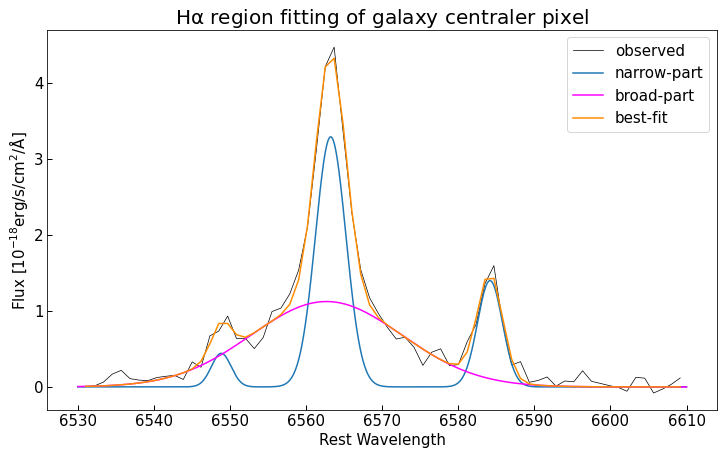

In [38]:
y,x = 24,25
ha_fit(pp_wave,spec_flux_rebin_Ha[:,y,x],spec_err_rebin_Ha[:,y,x],spec_con_rebin_Ha[:,y,x],
       plot=1,savefig=0,iter_on=0,broad_Ha=0)

## stack_spec

In [63]:
spec_rebin = fits.open("data/SDSSJ0228_rebin_specHa_10.fits")
spec_flux_rebin = spec_rebin[1].data
spec_err_rebin  = spec_rebin[2].data
spec_con_rebin  = spec_rebin[3].data

ppdata = fits.open("data/ppxf/SDSSJ0228_mask_ppxf_fitdata.fits")
pp_wave = ppdata[1].data["wavelength"]

ha_vmap = fits.open("data/SDSSJ0228_Ha_velocity.fits")
ha_vm_data = ha_vmap[1].data
Ha_snr_cut = (snr_ha_bin>10).reshape(50,50)

In [64]:
spec_annu = []
serr_annu = []
for yi in range(50):
    for xi in range(50):
        if Ha_snr_cut[yi,xi] == 1:
            spec_annu_i = spec_flux_rebin[:,yi,xi]
            serr_annu_i = spec_err_rebin[:,yi,xi]
            voff = ha_vm_data[yi,xi]

            if -4.5<voff/57<-3.5:
                spec_ai_new = np.append(np.array([0,0,0,0]),spec_annu_i[:-4])
                serr_ai_new = np.append(np.array([0,0,0,0]),serr_annu_i[:-4])
            elif -3.5<voff/57<-2.5:
                spec_ai_new = np.append(np.array([0,0,0]),spec_annu_i[:-3])
                serr_ai_new = np.append(np.array([0,0,0]),serr_annu_i[:-3])
            elif -2.5<voff/57<-1.5:
                spec_ai_new = np.append(np.array([0,0]),spec_annu_i[:-2])
                serr_ai_new = np.append(np.array([0,0]),serr_annu_i[:-2])
            elif -1.5<voff/57<-0.5:
                spec_ai_new = np.append(np.array([0]),spec_annu_i[:-1])
                serr_ai_new = np.append(np.array([0]),serr_annu_i[:-1])
            elif -0.5<voff/57<0.5:
                spec_ai_new = spec_annu_i
                serr_ai_new = serr_annu_i
            elif 0.5<voff/57<1.5:
                spec_ai_new = np.append(spec_annu_i[1:],np.array([0]))
                serr_ai_new = np.append(serr_annu_i[1:],np.array([0]))
            elif 1.5<voff/57<2.5:
                spec_ai_new = np.append(spec_annu_i[2:],np.array([0,0]))
                serr_ai_new = np.append(serr_annu_i[2:],np.array([0,0]))
            elif 2.5<voff/57<3.5:
                spec_ai_new = np.append(spec_annu_i[3:],np.array([0,0,0]))
                serr_ai_new = np.append(serr_annu_i[3:],np.array([0,0,0]))    
            elif 3.5<voff/57<4.5:
                spec_ai_new = np.append(spec_annu_i[4:],np.array([0,0,0,0]))
                serr_ai_new = np.append(serr_annu_i[4:],np.array([0,0,0,0])) 


            spec_annu.append(spec_ai_new)
            serr_annu.append(serr_ai_new)

spec_annu_stack = np.array(np.sum(spec_annu, axis=0))
spec_annu_stack_err = np.sqrt(np.sum(np.array(serr_annu)**2, axis=0))

({'pNIIa': array([5.81599995e+03, 6.54822029e+03, 1.18742069e+00]),
  'pNIIa_err': array([1.17441238e+02, 2.59611154e-02, 2.90429273e-02]),
  'pHa': array([5.08062602e+04, 6.56287774e+03, 1.56704058e+00]),
  'pHa_err': array([1.42917702e+02, 4.35542597e-03, 4.92542109e-03]),
  'pNIIb': array([2.06385637e+04, 6.58362471e+03, 1.52943524e+00]),
  'pNIIb_err': array([1.11917604e+02, 8.99621919e-03, 9.16826717e-03]),
  'pHa_borad': array([6999.14177362, 6561.6123659 ,    9.91524776]),
  'pHa_borad_err': array([66.61436963,  0.07868105,  0.09736522]),
  'chi2': 1864.2775219803348,
  'chi2_redused': 33.29067003536312},
 {'NIIa': 17310.871794826482,
  'Ha': 199566.3915164404,
  'NIIb': 79122.59061265623,
  'Ha_broad': 173955.55249371362,
  'NIIa_err': 451.186439479254,
  'Ha_err': 588.9070123561881,
  'NIIb_err': 556.8198376415124,
  'Ha_broad_err': 1368.8104087181769,
  'NIIa_v': -666.4703380374605,
  'Ha_v': 3.553839773723221,
  'NIIb_v': 951.9433544725749,
  'Ha_broad_v': -54.28936263157694

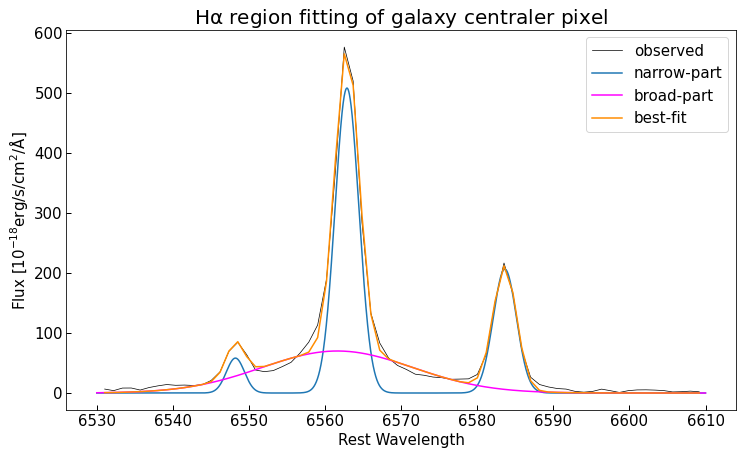

In [67]:
spec_con = np.full_like(spec_annu_stack,0)
ha_fit(pp_wave,spec_annu_stack,spec_annu_stack_err,spec_con,
       plot=1,savefig=0,iter_on=0,broad_Ha=0)

In [74]:
s_ha_ba = 9.91524776
s_ha_ba_err = 0.09736522

s_hab = (s_ha_ba/6562.8)*3*10**5
s_hab_err = (s_ha_ba_err/6562.8)*3*10**5
sigma_corr = 3*10**5/2988.96822493805/2.35

s_hab_corr = np.sqrt(s_hab**2 - sigma_corr**2)


In [78]:
s_hab_corr,s_hab_err

(451.2309351091361, 4.4507780215761565)

## new model test (failed

In [555]:
#### 定义拟合model
def Ga_model(x,*p):    
    model = p[0]/(p[2]*np.sqrt(2*np.pi))*np.exp(-0.5*(x - p[1])**2/p[2]**2)  
    for i in range(3,len(p),3):
        area = p[i]
        mean = p[i+1]
        sigma = p[i+2]
        model += area/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*(x - mean)**2/sigma**2) 
        
    return model

In [564]:
rebin_spec_Ha = fits.open('analyse_data_image/SDSSJ0228/SDSSJ0228_rebin_specHa_10.fits')
spec_flux_rebin_Ha = rebin_spec_Ha[1].data
spec_err_rebin_Ha = rebin_spec_Ha[2].data
spec_con_rebin_Ha = rebin_spec_Ha[3].data

y,x = 21,25
galaxy_wave = pp_wave
galaxy_flux = spec_flux_rebin_Ha[:,y,x]
galaxy_err = spec_err_rebin_Ha[:,y,x]
galaxy_con = spec_con_rebin_Ha[:,y,x]

#########         Ha region
mask_Ha = (galaxy_wave > 6552) & (galaxy_wave < 6572)
mask_NIIa = (galaxy_wave > 6538) & (galaxy_wave < 6558)
mask_NIIb = (galaxy_wave > 6573) & (galaxy_wave < 6593)
mask_hat = ((galaxy_wave > 6530) & (galaxy_wave < 6610))

fitha_wave = galaxy_wave[mask_hat]
fitha_flux = galaxy_flux[mask_hat]
fitha_err = galaxy_err[mask_hat]
fitha_con =galaxy_con[mask_hat]

flux_iNIIa = np.nansum(galaxy_flux[mask_NIIa])
flux_iHa = np.nansum(galaxy_flux[mask_Ha])   
flux_iNIIb = np.nansum(galaxy_flux[mask_NIIb])

In [565]:
##### init value set
### no broad Ha line 
# p_Ha = np.array([flux_iNIIa, 6548., 1,
#                 flux_iHa  , 6563., 1.,
#                 flux_iNIIb, 6584., 1.])

# p_Ha_bounds = ([0,6544,0,0,6559.5,1,0,6580,0],
#                [np.inf ,6552,2,np.inf ,6567  ,3, np.inf,6588,2])

# poptha,pcovha = curve_fit(Ga_model,fitha_wave,fitha_flux,p0=p_Ha,bounds=p_Ha_bounds,
#                          sigma=fitha_err,absolute_sigma=True,maxfev=100000)

# chi2_ha = np.sum((fitha_flux-Ga_model(fitha_wave,*poptha))**2/fitha_err**2)
# reduced_chi2_ha  = chi2_ha/(fitha_wave.shape[0] - poptha.shape[0])

###### broad line 
p_Hab = np.array([1000, 6548., 1.,
                  2000, 6563., 1.,
                  1000, 6584., 1.,
                  2000, 6563., 3.])

p_Hab_bounds = ([0,6544,0,0,6559,0,0,6580,0,0,6559,2],
                [np.inf,6552,2,np.inf,6567,2,np.inf,6588,2,np.inf,6567,5])
poptha_b,pcovha_b = curve_fit(Ga_model,fitha_wave,fitha_flux,p0=p_Hab,bounds=p_Hab_bounds,
                         sigma=fitha_err,absolute_sigma=True,maxfev=100000)

chi2_hab = np.sum((fitha_flux-Ga_model(fitha_wave,*poptha_b))**2/fitha_err**2)
reduced_chi2_hab  = chi2_hab/(fitha_wave.shape[0] - poptha_b.shape[0])

In [566]:
200/(3*10**5)*6563

4.375333333333333

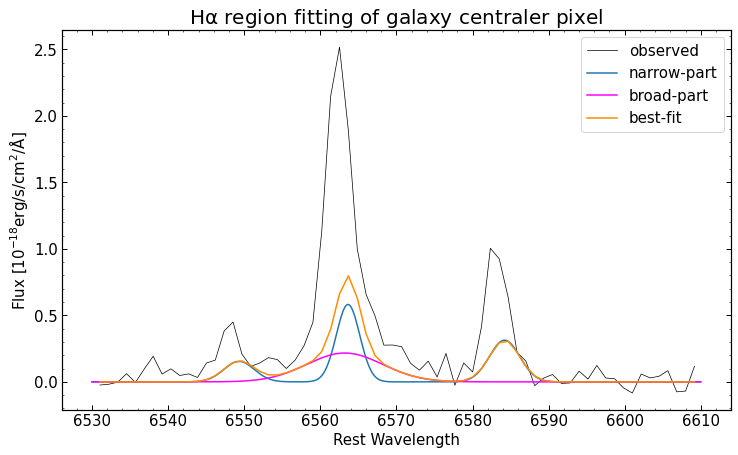

In [567]:
fig = plt.figure(figsize=(12,7))
fake_x = np.arange(6530,6610,0.01)

ax1 = fig.add_subplot(111)

ax1.plot(fitha_wave,fitha_flux*10**(-2),color='k', lw=0.7, alpha=1,label='observed')
ax1.set_xlabel('Rest Wavelength',fontsize = 15)
ax1.set_ylabel(r'${\rm Flux\ [10^{-18}erg/s/cm^2/\AA]}$', fontsize = 15)
ax1.set_title(r'${\rm H\alpha\ region\ fitting\ of\ galaxy\ centraler\ pixel}$',fontsize=20)
plt.legend(fontsize = 15.0,markerscale = 2)

ax1.plot(fake_x,Ga_model(fake_x,*popt_ha[0:9])*10**(-2),label='narrow-part',color='C0')

try:
    ax1.plot(fake_x,Ga_model(fake_x,*popt_ha[9:12])*10**(-2),label='broad-part',color='magenta')
except:
    pass

ax1.plot(fitha_wave,Ga_model(fitha_wave,*popt_ha)*10**(-2),color='darkorange',label='best-fit')

ax1.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
plt.legend(fontsize = 15.0,markerscale = 2)

## velocity field

In [14]:
rebin_spec_Ha = fits.open('data/SDSSJ0228_rebin_specHa_10.fits')
spec_flux_rebin_Ha = rebin_spec_Ha[1].data
spec_err_rebin_Ha = rebin_spec_Ha[2].data
spec_con_rebin_Ha = rebin_spec_Ha[3].data

In [17]:
vbx = np.arange(50)
vby = np.arange(50)
v_ha_narrow = np.zeros((50,50))
v_ha_broad = np.zeros((50,50))


for x,y in product(vbx,vby):
    fit_status,fit_flux = ha_fit(pp_wave,spec_flux_rebin_Ha[:,y,x],spec_err_rebin_Ha[:,y,x],spec_con_rebin_Ha[:,y,x],
       plot=0,savefig=0,iter_on=0,broad_Ha=0)
    
#     flux_han_bin[y,x] = fit_flux.get('Ha')
    v_ha_narrow[y,x]  = fit_flux.get('Ha_v')
    
    try:
#         flux_hab_bin[y,x] = fit_flux.get('Ha_broad')
        v_ha_broad[y,x] = fit_flux.get('Ha_broad_v')
    except:
#         flux_hab_bin[y,x] = np.nan
        v_ha_broad[y,x] = np.nan


In [18]:
###header     velocity data 
hdr = fits.Header()
hdr['level0'] = 'header'
hdr['level1'] = 'Ha_n velocity'
hdr['level2'] = 'Ha_b lc velocity'
hdr['object'] = 'SDSSJ0228'
hdr['redshift'] = 0.072;
hdr['v BUNIT'] = 'Kms**(-1)'

empty_primary = fits.PrimaryHDU(header=hdr)

### flux, error, bestfit

image_hdu1 = fits.ImageHDU(v_ha_narrow)
image_hdu2 = fits.ImageHDU(v_ha_broad)


hdul = fits.HDUList([empty_primary,image_hdu1,image_hdu2])
hdul.writeto('data/SDSSJ0228_Ha_velocity.fits', overwrite=True)

In [389]:
flux_han_binv1 = list(flux_han_bin.values())
flux_hab_binv1 = list(flux_hab_bin.values())
vhan_binv1 = list(vhan_bin.values())
vhab_binv1 = list(vhab_bin.values())

flux_hanb_v1 = np.array(flux_han_binv1)
flux_habb_v1 = np.array(flux_hab_binv1)
velo_hanb_v1 = np.array(vhan_binv1)
velo_habb_v1 = np.array(vhab_binv1)

binha_xx = np.array(binha_xx)
binha_yy = np.array(binha_yy)

In [22]:
snr_Ha_bin = []
for x,y in product(vbx,vby):
    yi,xi,si,ni,snr = signal_noise(y,x,vorbin=1,emline='Ha')
    if si.size != 0:
        snr_Ha_bin.append(snr[0])
    else:
        snr_Ha_bin.append(0)
snr_ha_bin = np.array(snr_Ha_bin)

### flux-v-map

/home/siro/anaconda3/lib/python3.8/site-packages/plotbin/sauron_colormap.py:105: UserWarning: Trying to register the cmap 'sauron' which already exists.
  plt.register_cmap(cmap=sauron)
/home/siro/anaconda3/lib/python3.8/site-packages/plotbin/sauron_colormap.py:106: UserWarning: Trying to register the cmap 'sauron_r' which already exists.
  plt.register_cmap(cmap=sauron_r)


Text(0, 0.5, 'pixel_y')

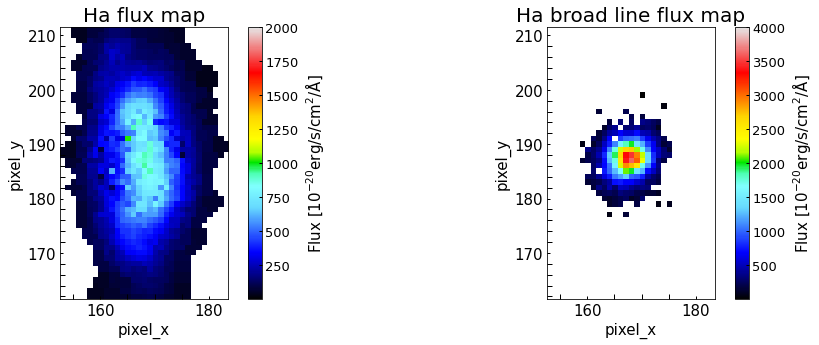

In [31]:
#### flux map
region_selet = np.logical_not(snr_ha_bin<3)

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.figure(figsize=(16,5))
plt.subplot(121)
ax1 = display_pixels(np.array(binha_xx)[region_selet],np.array(binha_yy)[region_selet],flux_hanb_v1[region_selet],vmin=1,vmax=2000)
cb = plt.colorbar(ax1)
cb.ax.tick_params(direction='in', labelsize = 13, length = 3, width=1.0)
cb.set_label(r'${\rm Flux\ [10^{-20}erg/s/cm^2/\AA]}$',fontsize = 15)
plt.tick_params(direction='in', labelsize = 15, length = 3, width=1.0)
plt.title("Ha flux map",fontsize = 20)
plt.xlabel('pixel_x',fontsize = 15.0)
plt.ylabel('pixel_y',fontsize = 15.0)
plt.subplot(122)
ax2 = display_pixels(np.array(binha_xx)[region_selet],np.array(binha_yy)[region_selet],flux_habb_v1[region_selet],vmin=1,vmax=4000)
cb = plt.colorbar(ax2)
cb.ax.tick_params(direction='in', labelsize = 13, length = 3, width=1.0)
cb.set_label(r'${\rm Flux\ [10^{-20}erg/s/cm^2/\AA]}$',fontsize = 15)
plt.tick_params(direction='in', labelsize = 15, length = 3, width=1.0)
plt.title("Ha broad line flux map",fontsize = 20)
plt.xlabel('pixel_x',fontsize = 15.0)
plt.ylabel('pixel_y',fontsize = 15.0)

Text(0, 0.5, 'pixel_y')

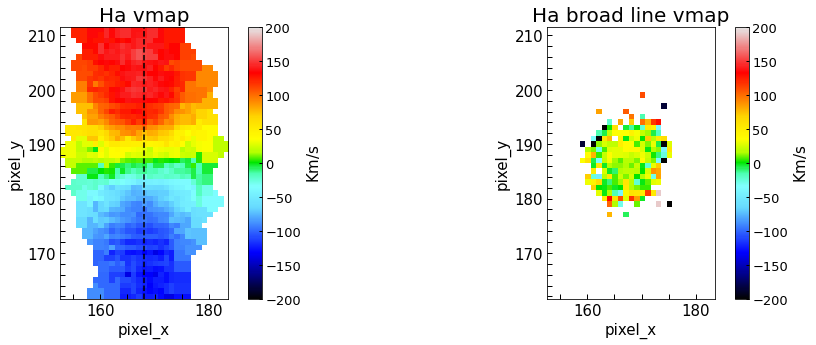

In [32]:
#### velocity map
region_selet = np.logical_not(snr_ha_bin<3)

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.figure(figsize=(16,5))
plt.subplot(121)
velo_hanb_v2 = velo_hanb_v1 - np.median(velo_hanb_v1)
ax1 = display_pixels(np.array(binha_xx)[region_selet],np.array(binha_yy)[region_selet],velo_hanb_v2[region_selet],vmin=-200,vmax=200)
plt.axvline(168,color='k',linestyle="--")
cb = plt.colorbar(ax1)
cb.ax.tick_params(direction='in', labelsize = 13, length = 3, width=1.0)
cb.set_label(r'${\rm Km/s}$',fontsize = 15)
plt.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
plt.title("Ha vmap",fontsize = 20)
plt.xlabel('pixel_x',fontsize = 15.0)
plt.ylabel('pixel_y',fontsize = 15.0)
plt.subplot(122)
ax2 = display_pixels(np.array(binha_xx)[region_selet],np.array(binha_yy)[region_selet],velo_habb_v1[region_selet],vmin=-200,vmax=200)
cb = plt.colorbar(ax2)
cb.ax.tick_params(direction='in', labelsize = 13, length = 3, width=1.0)
cb.set_label(r'${\rm Km/s}$',fontsize = 15)
plt.title("Ha broad line vmap",fontsize = 20)
plt.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
plt.xlabel('pixel_x',fontsize = 15.0)
plt.ylabel('pixel_y',fontsize = 15.0)

## v-map&rotation-curve 

In [393]:
### rc
from astropy.io import ascii
from astropy.table import Table
rc_data = ascii.read('analyse_data_image/SDSSJ0228/rotation_curve_error_v1.txt')
star_mass = ascii.read('analyse_data_image/SDSSJ0228/stellar_mass_surface_density.txt')
R_star = star_mass['R_total(kpc)']

R_star_mask = np.where(R_star<6)
bulge_v = rc_data['rc_bulge_v'][R_star_mask]
bulge_v_err = rc_data['rc_bulge_err'][R_star_mask]
disk_v = rc_data['rc_disk_v'][R_star_mask]
disk_v_err = rc_data['rc_disk_err'][R_star_mask]
gas_v = rc_data['rc_gas_v'][R_star_mask]
gas_v_err = rc_data['rc_gas_err'][R_star_mask] 
star_v = np.sqrt(bulge_v**2 + disk_v**2)
star_v_err = np.sqrt((bulge_v_err*bulge_v/star_v)**2+(disk_v_err*disk_v/star_v)**2)
baron_v = np.sqrt(star_v**2 + gas_v**2)
baron_v_err = np.sqrt((star_v_err*star_v/baron_v)**2+(gas_v_err*gas_v/baron_v)**2)

v_ha_data = ascii.read('analyse_data_image/SDSSJ0228/Ha_rotataion_velocity.txt')
v_circ_data = ascii.read('analyse_data_image/SDSSJ0228/asymmetric_draft_correction.txt')
v_circ = v_circ_data["v_circ"]
v_circ_err = v_circ_data["v_circ_err"]
v_p = v_circ_data["v_p"]
v_p_err = v_circ_data["v_p_err"]

dist = 335.8     
snr_x = np.arange(-25,25,1)
snr_mask = np.where(np.abs(snr_x)<19)
kpc_perpix = (0.2/2.06e5)*dist*1.0e3
radius = np.array(v_ha_data['R(kpc)'])[snr_mask]*(kpc_perpix/0.3) 
radii = radius[0:radius.shape[0]:2]
v_ha = np.array(v_ha_data['v_Ha_ro'])[snr_mask]
Ha_v = v_ha[0:v_ha.shape[0]:2]
v_ha_err = np.array(v_ha_data['v_Ha_ro_error'])[snr_mask]
Ha_v_err = v_ha_err[0:v_ha_err.shape[0]:2]

# Ha_region_data = fits.open('analyse_data_image/SDSSJ0228/SDSSj0228_ha_flux.fits')

# Hana_f     = Ha_region_data[1].data
# Hana_f[np.isnan(Hana_f)] = 0
# Habr_f     = Ha_region_data[3].data
# Habr_f[np.isnan(Habr_f)] = 0
# Hana_ferr  = Ha_region_data[2].data
# Hana_ferr[np.isnan(Hana_ferr)] = 0
# Habr_ferr  = Ha_region_data[4].data
# Habr_ferr[np.isnan(Habr_ferr)] = 0
# Ha_f       = Hana_f + Habr_f
# Ha_ferr    = np.sqrt(Hana_ferr**2 + Habr_ferr**2)
# ha_snr = (Ha_f/Ha_ferr).flatten()

In [50]:
radius[21:].shape

(16,)

(-20.0, 180.0)

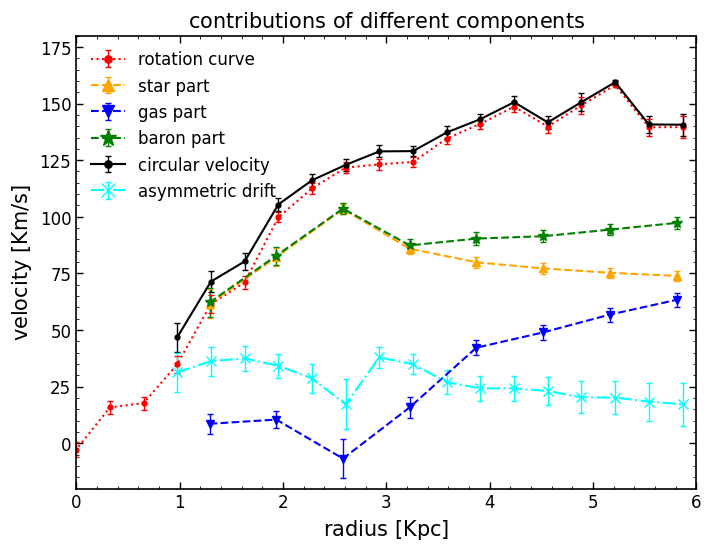

In [517]:
plt.figure(figsize=(8,6),dpi = 100)
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True

plt.errorbar(radius,v_ha,yerr=v_ha_err,color='r',fmt='.:',elinewidth=1,ms=7,capsize=2,label='rotation curve')
plt.errorbar(R_star[R_star_mask],star_v,yerr=star_v_err,color='orange',fmt='^--',elinewidth=1,ms=6,capsize=2,label = 'star part')
plt.errorbar(R_star[R_star_mask],gas_v,yerr=gas_v_err,color='blue',fmt='v--',elinewidth=1,ms=6,capsize=2,label = 'gas part')
plt.errorbar(R_star[R_star_mask],baron_v,yerr=baron_v_err,color='green',fmt='*--',elinewidth=1,ms=8,capsize=2,label ='baron part')
plt.errorbar(radius[21:],v_circ,yerr=v_circ_err,color='black',fmt='.-',elinewidth=1,ms=7,capsize=2,label='circular velocity')
plt.errorbar(radius[21:],v_p,yerr=v_p_err,color='cyan',fmt='x-.',elinewidth=1,ms=7,capsize=2,label='asymmetric drift')


plt.tick_params(direction='in', labelsize = 12, length = 5, width=1.0)
plt.ylabel(r'${\rm velocity\ [Km/s]}$',fontsize=15)
plt.xlabel(r'${\rm radius\ [Kpc]}$',fontsize=15)
plt.title(r'${\rm contributions\ of\ different\ components}$',fontsize=15)
plt.legend(fontsize = 12.0,markerscale = 1.5,framealpha=0)
plt.xlim(0,6)
plt.ylim(-20,180)

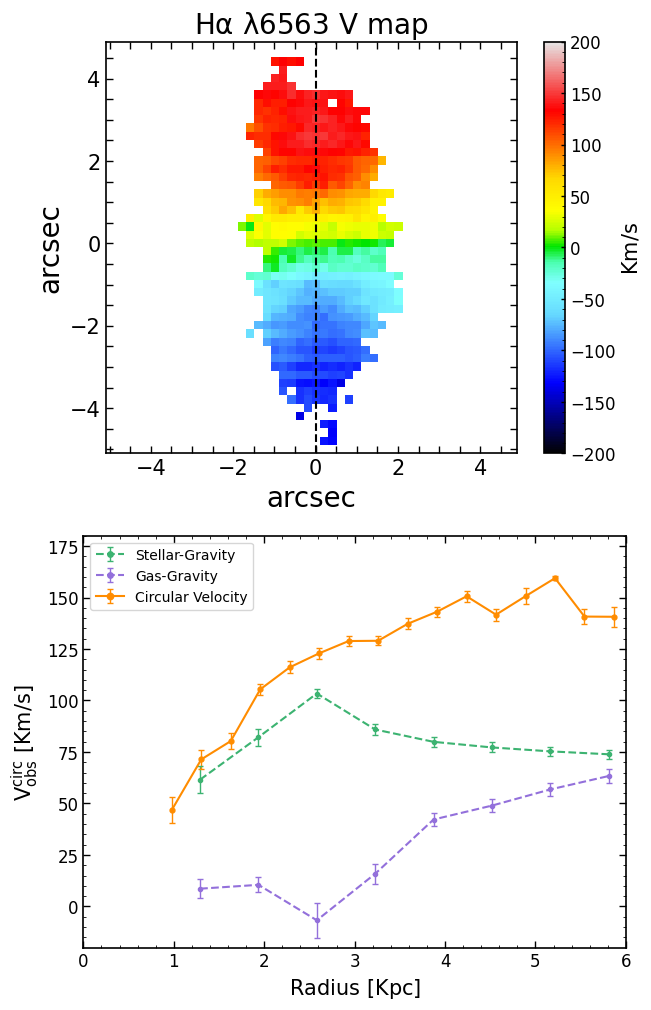

In [518]:
plt.figure(figsize=(7,12),dpi = 100)
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True

savefig = 0

nx = (np.arange(50) - 50/2)/5.
ny = (np.arange(50) - 50/2)/5.
xpos, ypos = np.meshgrid(nx, ny, sparse=False, indexing='xy')

ax_vmap = plt.subplot(211)

region_selet = np.logical_not(snr_ha_bin<10)
velo_hanb_v2 = velo_hanb_v1 - np.median(velo_hanb_v1)

Ha_vel = np.full_like(velo_hanb_v2,np.nan)
Ha_vel[region_selet] = velo_hanb_v2[region_selet]
ax_vmap = display_pixels(ypos, xpos, Ha_vel,vmin=-200,vmax=200)
plt.axvline(0,color='k',linestyle="--")
cb = plt.colorbar(ax_vmap)
cb.ax.tick_params(direction='in', labelsize = 12, length = 3, width=1.0)
cb.set_label(r'${\rm Km/s}$',fontsize = 15)
plt.title(r'${\rm H\alpha\ \lambda 6563\ V\ map}$',fontsize = 20)
plt.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
plt.xlabel('arcsec',fontsize = 20)
plt.ylabel('arcsec',fontsize = 20)


ax_rc = plt.subplot(212)

# plt.errorbar(radius,v_ha,yerr=v_ha_err,color='r',fmt='.:',elinewidth=1,ms=7,capsize=2,label='rotation curve')
plt.errorbar(R_star[R_star_mask],star_v,yerr=star_v_err,color='mediumseagreen',fmt='.--',elinewidth=1,ms=6,capsize=2,label = 'Stellar-Gravity')
plt.errorbar(R_star[R_star_mask],gas_v,yerr=gas_v_err,color='mediumpurple',fmt='.--',elinewidth=1,ms=6,capsize=2,label = 'Gas-Gravity')
# plt.errorbar(R_star[R_star_mask],baron_v,yerr=baron_v_err,color='green',fmt='*--',elinewidth=1,ms=8,capsize=2,label ='baron part')
plt.errorbar(radius[21:],v_circ,yerr=v_circ_err,color='darkorange',fmt='.-',elinewidth=1,ms=7,capsize=2,label='Circular Velocity')
# plt.errorbar(radius[21:],v_p,yerr=v_p_err,color='cyan',fmt='x-.',elinewidth=1,ms=7,capsize=2,label='asymmetric drift')

plt.tick_params(direction='in', labelsize = 12, length = 5, width=1.0)
plt.ylabel(r'${\rm V^{circ}_{obs}\ [Km/s]}$',fontsize=15)
plt.xlabel(r'${\rm Radius\ [Kpc]}$',fontsize=15)
# plt.title(r'${\rm contributions\ of\ different\ components}$',fontsize=15)
plt.legend(fontsize = 10.0,markerscale = 1.3)
plt.xlim(0,6)
plt.ylim(-20,180)

if savefig:
    plt.savefig('vel-map-and-rc.pdf',dpi=600,bbox_inches='tight')

## rotation curve

In [ ]:
##### 沿major axis计算速度
'''没bin过的'''
# vr_ha_nb = {}
# vr_b_nb = {}
# x_ro = 168
# y_ro = np.arange(162,212)
# for y in y_ro:
#     fit_status,fit_flux = ha_fit(y,x_ro,plot=0,vorbin=0,savefig=0)
#     vr_ha_nb[y,x] = fit_flux.get('Ha_v')
    
#     try:
#         vr_b_nb[y,x] = fit_flux.get('Ha_broad_v')
#     except:
#         vr_b_nb[y,x] = np.nan
        
# vr_ha_nbin = list(vr_ha_nb.values())
# vr_ha_nbin_v1 = vr_ha_nbin - np.median(vr_ha_nbin)

# yy=[]
# snr_ha_nb = []

# for y in y_ro:
#     yi,xi,si,ni,snr = signal_noise(y,x_ro,vorbin=0,emline='Ha')
#     yy.append(yi)
#     if si.size != 0:
#         snr_ha_nb.append(snr[0])
#     else:
#         snr_ha_nb.append(0)

'''vorbin '''      
vr_ha_bin = {}
vr_b_b = {}
xr_ha_bin = 168-142
yr_ha_bin = np.arange(162,212)-162
for y in yr_ha_bin:
    fit_status,fit_flux = ha_fit(y,xr_ha_bin,plot=0,vorbin=1,savefig=0)
    vr_ha_bin[y,x] = fit_flux.get('Ha_v')
    
    try:
        vr_b_b[y,x] = fit_flux.get('Ha_broad_v')
    except:
        vr_b_b[y,x] = np.nan
        
vrha_bin = list(vr_ha_bin.values())
vrha_bin_v1 = vrha_bin - np.median(vrha_bin)

In [25]:
'''vor bin OIII minor velosity (v50,v80)'''
vnarrow_bin = {}
v50_O3_bin = {}
v80_O3_bin = {}
xc_O3 = np.arange(160,180)-142
yc_O3 = 187-162
for x in xc_O3:
    fit_status,fit_flux = OIII_5007_fit(yc_O3,x,plot=0,vorbin=1)
    vnarrow_bin[x] = fit_flux['OIII[5007]_v']
    
    if 'OIII[5007]_broad_v50' in  fit_flux.keys():
        v50_O3_bin[x] = fit_flux.get('OIII[5007]_broad_v50')
        v80_O3_bin[x] = fit_flux.get('OIII[5007]_broad_v80')
    else:
        v50_O3_bin[x] = np.nan
        v80_O3_bin[x] = np.nan
        
v50_O3_v1 = list(v50_O3_bin.values())
v80_O3_v1 = list(v80_O3_bin.values())

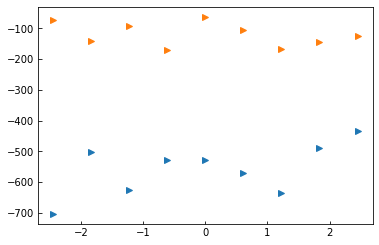

In [38]:
d_O3_bin=np.array([(0.3/np.median(e[e_slect]))*(i-25) for i in xc_O3])
plt.plot(d_O3_bin,v80_O3_v1,'C0>')
plt.plot(d_O3_bin,v50_O3_v1,'C1>')

Text(0.5, 1.0, 'rotation curve from Ha vorbin data')

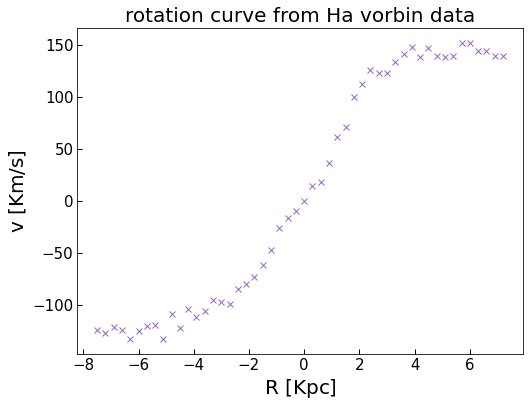

In [58]:
############# 作图
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.figure(figsize=(8,6))

kpc_perpix = 0.32561253
smaxis = isolist.sma
e = isolist.eps
e_slect = np.logical_and(smaxis>10,smaxis<30)
inclination = np.arccos(np.median(e[e_slect]))
f_i = np.sin(inclination)

## plt.subplot(121)

# vr_ha_nbin_v2 = vr_ha_nbin_v1/f_i
# d_ro_ha_nb = np.array([0.3*(i-189) for i in y_ro])
# ro_se = np.logical_not(np.array(snr_ha_nb)<3)

# plt.plot(d_ro_ha_nb[ro_se],vr_ha_nbin_v2[ro_se],'C1x')
# plt.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
# plt.ylabel(r'${\rm v\ [Km/s]}$',fontsize=20)
# plt.xlabel(r'${\rm R\ [Kpc]}$',fontsize=20)
# plt.title(r'rotation curve from Ha nobin data',fontsize=20)

# plt.subplot(122)

d_ro_ha_b=np.array([0.3*(i-25) for i in yr_ha_bin])
vr_ha_bin_v2 = vrha_bin_v1-4/f_i

plt.plot(d_ro_ha_b,vr_ha_bin_v2,'C4x',label='rotation curve')
# plt.axvline(4,color='r',linestyle="--")
# plt.axvline(-4,color='r',linestyle="--")
# plt.plot(0,0,'r*')

plt.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
plt.ylabel(r'${\rm v\ [Km/s]}$',fontsize=20)
plt.xlabel(r'${\rm R\ [Kpc]}$',fontsize=20)
plt.title(r'rotation curve from Ha vorbin data',fontsize=20)


# plt.plot(d_O3_bin,v80_O3_v1,'C0>',label='outflow-v80')
# plt.plot(d_O3_bin,v50_O3_v1,'C1>',label='outflow-v50')
# plt.legend(fontsize = 12.0,markerscale = 1.5,loc='lower right')

# plt.ylim(-800,200)

In [378]:
inclination = np.arccos(np.median(e[e_slect]))
f_i = np.sin(inclination)
f_i

0.8718036313701127

## rotation curve vs outflow velocity

In [51]:
from astropy.io import ascii
from astropy.table import Table
v_ha_data = ascii.read('analyse_data_image/SDSSJ0228/Ha_rotataion_velocity.txt')
v_O3_data = ascii.read('analyse_data_image/SDSSJ0228/O3_outflow_velocity.txt')

In [52]:
radius_ha = v_ha_data['R(kpc)']
v_ha = v_ha_data['v_Ha_ro']
v_ha_err = v_ha_data['v_Ha_ro_error']

radius_O3 = v_O3_data['R(kpc)']
v50_O3 = v_O3_data['v50_O3_broad']
v50_O3_err = v_O3_data['v50_O3_broad_error']
v80_O3 = v_O3_data['v80_O3_broad']
v80_O3_err = v_O3_data['v80_O3_broad_error']

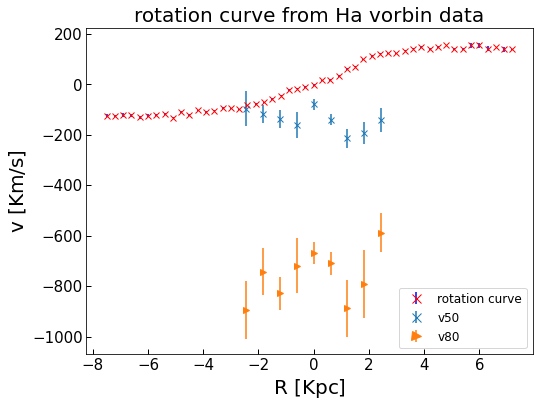

In [53]:
plt.figure(figsize=(8,6))

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.errorbar(radius_ha,v_ha,yerr=v_ha_err,fmt='rx',ecolor='b',label='rotation curve')
plt.errorbar(radius_O3,v50_O3,yerr=v50_O3_err,fmt='x',label='v50')
plt.errorbar(radius_O3,v80_O3,yerr=v80_O3_err,fmt='>',label='v80')

plt.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
plt.ylabel(r'${\rm v\ [Km/s]}$',fontsize=20)
plt.xlabel(r'${\rm R\ [Kpc]}$',fontsize=20)
plt.title(r'rotation curve from Ha vorbin data',fontsize=20)
plt.legend(fontsize = 12.0,markerscale = 1.5,loc='lower right')

In [55]:
radius_ha = v_ha_data['R(kpc)']
v_ha = v_ha_data['v_Ha_ro']
v_ha_err = v_ha_data['v_Ha_ro_error']
half_gn0 = np.logical_not(v_ha<0)
half_ln0 = np.logical_not(v_ha>0)
v_ha_gn0_log = np.log10(np.abs(v_ha[half_gn0]))
v_ha_ln0_log = -np.log10(np.abs(v_ha[half_ln0]))
v_ha_log_v1 = [v_ha_ln0_log,v_ha_gn0_log]
v_ha_log = [y for x in v_ha_log_v1 for y in x]
v_ha_err_log = np.sqrt(v_ha_err**2/v_ha**2)/(np.log(10))

radius_O3 = v_O3_data['R(kpc)']
v50_O3 = v_O3_data['v50_O3_broad']
v50_O3_err = v_O3_data['v50_O3_broad_error']
v50_O3_log = -np.log10(np.abs(v50_O3))
v50_O3_err_log = np.sqrt(v50_O3_err**2/v50_O3**2)/(np.log(10))
v80_O3 = v_O3_data['v80_O3_broad']
v80_O3_err = v_O3_data['v80_O3_broad_error']
v80_O3_log = -np.log10(np.abs(v80_O3))
v80_O3_err_log = np.sqrt(v80_O3_err**2/v80_O3**2)/(np.log(10))

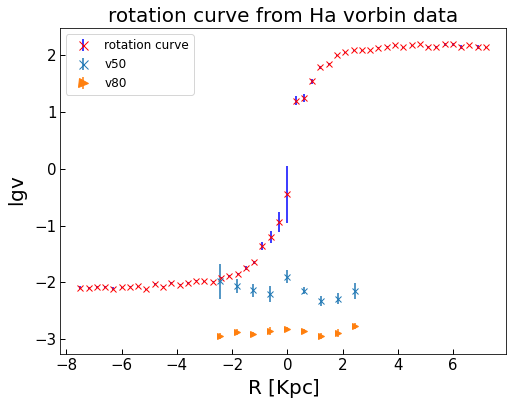

In [57]:
plt.figure(figsize=(8,6))

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.errorbar(radius_ha,v_ha_log,yerr=v_ha_err_log,fmt='rx',ecolor='b',label='rotation curve')
plt.errorbar(radius_O3,v50_O3_log,yerr=v50_O3_err_log,fmt='x',label='v50')
plt.errorbar(radius_O3,v80_O3_log,yerr=v80_O3_err_log,fmt='>',label='v80')

plt.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
plt.ylabel(r'${\rm lgv}$',fontsize=20)
plt.xlabel(r'${\rm R\ [Kpc]}$',fontsize=20)
plt.title(r'rotation curve from Ha vorbin data',fontsize=20)
plt.legend(fontsize = 12.0,markerscale = 1.5,loc='best')

(0.0, 10.0)

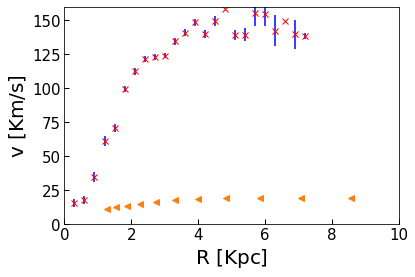

In [116]:
plt.errorbar(radius_ha,v_ha,yerr=v_ha_err,fmt='rx',ecolor='b',label='rotation curve')

plt.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
plt.ylabel(r'${\rm v\ [Km/s]}$',fontsize=20)
plt.xlabel(r'${\rm R\ [Kpc]}$',fontsize=20)
rad_kpc_r = np.array([ 1.27394543,  1.54147397,  1.8651835 ,  2.25687203,  2.73081516,
        3.30428634,  3.99818647,  4.83780563,  5.85374482,  7.08303123,
        8.57046779, 10.37026602, 12.54802189])
star_rov = np.array([11.120495,12.397922,13.639545,15.225530,16.567190,17.670395,18.593520,19.193835,
                     19.607224,19.712789,19.700848, 19.542359,21.642798])
plt.plot(rad_kpc_r,star_rov,'C1<')
plt.ylim(0,160)
plt.xlim(0,10)

## 产生速度误差

In [432]:
import random
test_spec = spec_data[:,187,167]
test_err = np.sqrt(spec_err[:,187,167])

In [439]:
random.gauss(test_spec[1600], test_err[1600])

85.24991086760829

In [442]:
rebin_spec_Ha = fits.open('SDSSJ0228_rebin_specHa_10.fits',memmap=True)
spec_data_rebin_Ha = rebin_spec_Ha[1].data
spec_err_rebin_Ha = rebin_spec_Ha[2].data
spec_con_rebin_Ha = rebin_spec_Ha[3].data

In [446]:
galaxy_wave = pp_wave
galaxy_flux = spec_data_rebin_Ha[:,25,25]
galaxy_err = spec_err_rebin_Ha[:,25,25]
mask_hat = ((galaxy_wave > 6530) & (galaxy_wave < 6610))

fitha_wave = galaxy_wave[mask_hat]
fitha_flux = galaxy_flux[mask_hat]
fitha_err = galaxy_err[mask_hat]


In [460]:
def generate_spectra(flux,error):
    
    if flux.shape[0] == error.shape[0]:
        pass
    else:
        print('flux and error must be same shape !')
        
    random_spec = []
    for i in range(flux.shape[0]):
        mu_flux = flux[i]
        sigma_flux = error[i]
        random_spec_i = random.gauss(mu_flux,sigma_flux)
        random_spec.append(random_spec_i)
    return random_spec

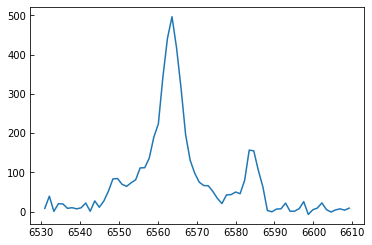

In [465]:
random_haspec = generate_spectra(fitha_flux,fitha_err)
plt.plot(fitha_wave,random_haspec)

# 面亮度轮廓拟合

In [1]:
from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAperture
from photutils.isophote import Ellipse

In [4]:
J0228_rband = fits.open("analyse_data_image/SDSSJ0228/J0228_rband_img.fits")
imgdata = J0228_rband[0].data
# plt.imshow(imgdata,origin='lower')

(142.0, 192.0)

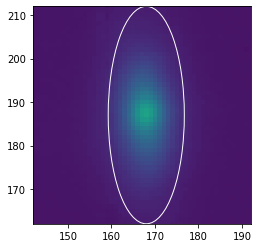

In [5]:
geometry = EllipseGeometry(x0=168, y0=187, sma=25, eps=0.65,
                           pa=90.*np.pi/180.)
aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                           geometry.sma*(1 - geometry.eps),
                           geometry.pa)
plt.imshow(imgdata, origin='lower')
aper.plot(color='white')
plt.ylim(162,212)
plt.xlim(142,192)

In [6]:
ellipse = Ellipse(imgdata, geometry)
isolist = ellipse.fit_image()

Text(0, 0.5, '$\\rm{y0}}$')

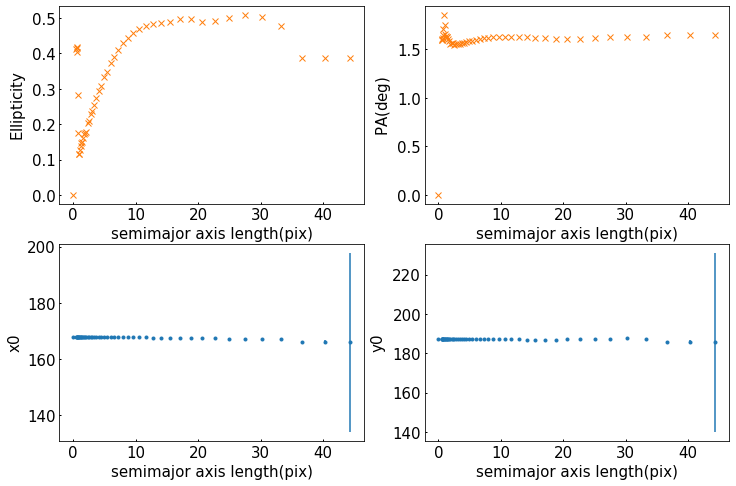

In [7]:
#### eps pa x0 y0
fig,axs = plt.subplots(2,2,figsize=(12,8))

axs[0,0].plot(isolist.sma, isolist.eps,'C1x')
axs[0,0].tick_params(direction='in', labelsize = 15, length = 2, width=1.0)
# axs[0,0].set_title(r'$\rm{Ellipticity}}$',fontsize=20)
axs[0,0].set_xlabel('semimajor axis length(pix)',fontsize=15)
axs[0,0].set_ylabel(r'$\rm{Ellipticity}}$',fontsize=15)

axs[0,1].plot(isolist.sma, isolist.pa, 'C1x')
axs[0,1].tick_params(direction='in', labelsize = 15, length = 2, width=1.0)
# axs[0,1].set_title(r'$\rm{PA}}$',fontsize=20)
axs[0,1].set_xlabel('semimajor axis length(pix)',fontsize=15)
axs[0,1].set_ylabel(r'$\rm{PA(deg)}}$',fontsize=15)

axs[1,0].errorbar(isolist.sma, isolist.x0, yerr = isolist.x0_err, fmt = 'C0.')
axs[1,0].tick_params(direction='in', labelsize = 15, length = 2, width=1.0)
# axs[1,0].set_title(r'$\rm{X}}$',fontsize=20)
axs[1,0].set_xlabel('semimajor axis length(pix)',fontsize=15)
axs[1,0].set_ylabel(r'$\rm{x0}}$',fontsize=15)

axs[1,1].errorbar(isolist.sma, isolist.y0, yerr = isolist.y0_err, fmt = 'C0.')
axs[1,1].tick_params(direction='in', labelsize = 15, length = 2, width=1.0)
# axs[1,1].set_title(r'$\rm{Y}}$',fontsize=20)
axs[1,1].set_xlabel('semimajor axis length(pix)',fontsize=15)
axs[1,1].set_ylabel(r'$\rm{y0}}$',fontsize=15)

In [8]:
isolist

In [9]:
from photutils.isophote import build_ellipse_model
model_image = build_ellipse_model(imgdata.shape, isolist)
residual = imgdata - model_image

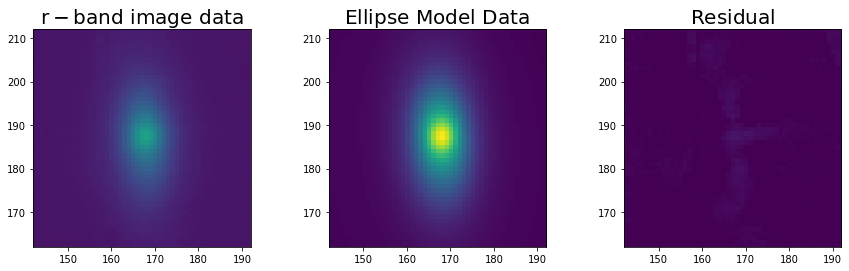

In [11]:
fig2,axs2 = plt.subplots(1,3,figsize=(15,4))

axs2[0].imshow(imgdata,origin='lower')
axs2[0].set_title(r'$\rm{r-band\ image\ data}$',fontsize=20)
axs2[0].set_ylim(162,212)
axs2[0].set_xlim(142,192)

axs2[1].imshow(model_image,origin='lower')
axs2[1].set_title(r'$\rm{Ellipse\ Model\ Data}$',fontsize=20)
axs2[1].set_ylim(162,212)
axs2[1].set_xlim(142,192)

axs2[2].imshow(residual,origin='lower',vmin=0,vmax=50)
axs2[2].set_title(r'$\rm{Residual}$',fontsize=20)
axs2[2].set_ylim(162,212)
axs2[2].set_xlim(142,192)

smas = np.linspace(5, 25, 7)
# for sma in smas:
#     iso = isolist.get_closest(sma)
#     x, y, = iso.sampled_coordinates()
#     axs2[0].plot(x, y, color='C9')
# #     axs2[1].plot(x, y, color='C9')

In [375]:
smaxis = isolist.sma
e = isolist.eps
e_slect = np.logical_and(smaxis>10,smaxis<30)
np.median(e[e_slect])

0.48985551781100156

In [48]:
isolist.x0

array([167.90969364, 167.90969364, 167.89997664, 167.88935471,
       167.87253422, 167.83051408, 167.79178675, 167.76211717,
       167.76211717, 167.76622174, 167.77537489, 167.78639389,
       167.79770877, 167.79687242, 167.79936372, 167.79952079,
       167.79556506, 167.78194142, 167.77523598, 167.79823247,
       167.79639808, 167.7845806 , 167.78968508, 167.78994978,
       167.78989049, 167.78041626, 167.77792307, 167.77609375,
       167.7668808 , 167.75899748, 167.75327229, 167.75082936,
       167.73950938, 167.73896504, 167.71948306, 167.68874616,
       167.64719474, 167.62399225, 167.62576794, 167.59507283,
       167.4021855 , 167.35646335, 167.29917822, 167.24894402,
       167.12283117, 167.21524792, 165.92618073, 165.92618073,
       165.92618073])

In [4]:
np.cos(0.4898)

0.8824269661404711

# SII 


## SII broad component chk

In [599]:
z       = 0.072
c       = 299792.458  # speed of light in km/s

file    = 'data/SDSSJ0228_spec_resample_region_select.fits'
hdu     = fits.open(file)
data    = hdu[0].data
data_var= hdu[1].data

head    = hdu[0].header
wave    = 10**( head['CRVAL3'] + np.arange(head['NAXIS3'])*head['CD3_3'] )    

num_xspa = head['NAXIS1']
num_yspa = head['NAXIS2']
#
restwave = wave/(1+z)

jj,ii = 12,12
flux    = data[:,jj,ii]
var     = data_var[:,jj,ii]
flux     = np.sqrt(np.abs(var))

In [570]:
#### 高斯模型
def gaussian(x,*p):
    model = p[0]*np.exp(-0.5*(x - p[1])**2/p[2]**2)  
    for i in range(3,len(p),3):
        amp = p[i]
        mean = p[i+1]
        sigma = p[i+2]
        model += amp*np.exp(-0.5*(x - mean)**2/sigma**2) 
        
    return model

In [605]:
#################    set Initial value    ############################
name = ['SII[6717]','SII[6731]']
mask_SII = ((restwave > 6700) & (restwave < 6750))
fit_wave = restwave[mask_SII]
fit_spec = flux[mask_SII] * 10**18 -3

fit_err = err[mask_SII] * 10**18
########    start fitting 
p0n = np.array([4, 6717., 1.,
               4, 6731., 1.,])
p0n_bounds = ([0,6712,0,0,6726,0],
             [np.inf,6722,2,np.inf,6736,2])

p0b = np.array([4, 6717., 1.,
               4, 6731., 1.,
               4, 6717., 3.,
               4, 6731., 3.,])
p0b_bounds = ([0,6712,0,0,6726,0,0,6712,0,0,6726,0],
             [np.inf,6722,2,np.inf,6736,2,np.inf,6722,5,np.inf,6736,5])
popt,pcov = curve_fit(gaussian,fit_wave,fit_spec,p0=p0b,bounds=p0b_bounds,
                      sigma=fit_err,absolute_sigma=True,maxfev=100000)

chi2 = np.sum((fit_spec-gaussian(fit_wave,*popt))**2/fit_err**2)
reduced_chi2 = chi2/(fit_wave.shape[0] - popt.shape[0])
print('CHI2 = %#3.5g; reduced CHI2 = %#3.5g; freedom: %#3.5g  ' % (chi2,reduced_chi2,fit_wave.shape[0]))

CHI2 = 44.034; reduced CHI2 = 1.6936; freedom: 38.000  


In [601]:
fit_err

array([0.0825259 , 0.08360741, 0.08518851, 0.08409887, 0.07993748,
       0.07758806, 0.0787526 , 0.08077651, 0.08103711, 0.08044313,
       0.08283217, 0.08722083, 0.09845243, 0.10018606, 0.08725526,
       0.08216191, 0.08074694, 0.0793788 , 0.07695336, 0.07516107,
       0.07619884, 0.07590501, 0.08024366, 0.08535854, 0.08416741,
       0.08058559, 0.07880544, 0.08075931, 0.08072058, 0.07919704,
       0.07771929, 0.07690065, 0.08087228, 0.07747114, 0.07900816,
       0.08145481, 0.08334889, 0.08194442])

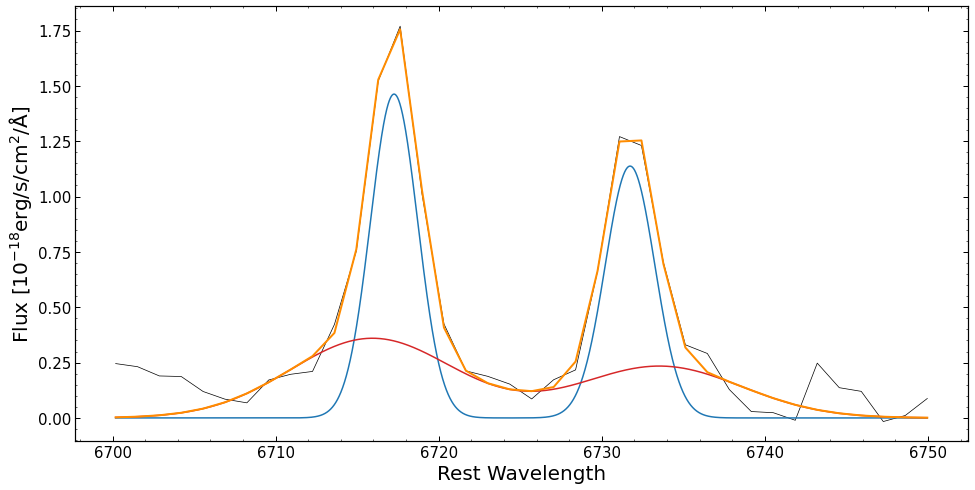

In [606]:
plt.figure(figsize=(16,8))
plt.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
plt.ylabel(r'${\rm Flux\ [10^{-18}erg/s/cm^2/\AA]}$',fontsize=20)
plt.xlabel('Rest Wavelength',fontsize=20)

plt.plot(fit_wave,fit_spec,color='k', lw=0.7, alpha=1,label='observed')

fake_x = np.arange(fit_wave[0],fit_wave[-1],0.01)
plt.plot(fake_x,gaussian(fake_x,*popt[0:6]),color='C0',label='narrow-part')
try:
    plt.plot(fake_x,gaussian(fake_x,*popt[6:12]),color='C3',label='broad-part')
except:
    pass

plt.plot(fit_wave,gaussian(fit_wave,*popt),color='darkorange',lw=2,label='best-fit')

In [603]:

S2_Kinem = spec_fit.emline_fit_properties(fit_wave, fit_err, fit_spec, popt[0:6], mode='S2')
S2_Kinem

{'SII[6717]_flux': 8.338141078964501,
 'SII[6731]_flux': 6.351544024775233,
 'SII[6717]_fluxerr': 0.37880775156848717,
 'SII[6731]_fluxerr': 0.36590438021518557,
 'SII[6717]_velocity': nan,
 'SII[6731]_velocity': nan,
 'SII[6717]_EW': 43.10812377180211,
 'SII[6731]_EW': 32.8374326326539}

In [604]:
S2_R = S2_Kinem["SII[6717]_flux"]/S2_Kinem["SII[6731]_flux"]
S2_R_err = np.sqrt((S2_Kinem["SII[6717]_fluxerr"]/S2_Kinem["SII[6731]_flux"])**2 +
                   ((S2_Kinem["SII[6717]_flux"]*S2_Kinem["SII[6731]_fluxerr"])/S2_Kinem["SII[6731]_flux"]**2)**2)
x
fa = 627.1
fb = 2107
fc = 0.4315
Ne = (fa*S2_R-fc*fb)/(fc - S2_R)
Ne_err = np.sqrt((((fa*(fc - S2_R)+(fa*S2_R-fc*fb)) * S2_R_err) / (fc - S2_R) ** 2)**2)
Ne,Ne_err

(97.50657933749498, 79.19213202017413)

## $\ n_e$

In [611]:
from pkg.MUSE_data_reduce import spec_fit

# rebin_data_Ha = fits.open('analyse_data_image/SDSSJ0228/SDSSJ0228_rebin_specHa_10.fits')
# spec_flux_rebin_Ha = rebin_data_Ha[1].data
# spec_err_rebin_Ha  = rebin_data_Ha[2].data
# spec_con_rebin_Ha  = rebin_data_Ha[3].data

vbx = np.arange(50)
vby = np.arange(50)
flux_S2_a   = np.zeros((50,50))
flux_S2_b   = np.zeros((50,50))
flux_S2_a_err   = np.zeros((50,50))
flux_S2_b_err    = np.zeros((50,50))
for x,y in product(vbx,vby):
   
    Status,Kinem = spec_fit.emline_fit(pp_wave,spec_flux_rebin_Ha[:,y,x],spec_err_rebin_Ha[:,y,x],spec_con_rebin_Ha[:,y,x],
                                       plot=0,mode ='S2')
    
    flux_S2_a[x,y]     = Kinem.get('SII[6717]_flux')
    flux_S2_b[x,y]     = Kinem.get('SII[6731]_flux')
    flux_S2_a_err[x,y] = Kinem.get('SII[6717]_fluxerr')
    flux_S2_b_err[x,y] = Kinem.get('SII[6731]_fluxerr')

In [308]:
# save fits file
hdr = fits.Header()
hdr['level0'] = 'header'
hdr['level1'] = 'SII[6717]_flux'
hdr['level2'] = 'SII[6717]_flux_error'
hdr['level3'] = 'SII[6731]_flux'
hdr['level4'] = 'SII[6731]_flux_error'
hdr['object'] = 'SDSSJ0228'
hdr['redshift'] = 0.072;
hdr['fluxBUNIT'] = '10**(-20)erg.s**(-1).cm**(-2)'
hdr['COMMENT'] = "SII 17,31 flux from rebined ha data "

empty_primary = fits.PrimaryHDU(header=hdr)
### flux, error, bestfit
image_hdu1 = fits.ImageHDU(flux_S2_a)
image_hdu2 = fits.ImageHDU(flux_S2_a_err)
image_hdu3 = fits.ImageHDU(flux_S2_b)
image_hdu4 = fits.ImageHDU(flux_S2_b_err)

hdul = fits.HDUList([empty_primary,image_hdu1, image_hdu2,image_hdu3,image_hdu4])
hdul.writeto('SDSSj0228_SII_flux.fits', overwrite=True)

In [23]:
S2_data = fits.open('data/SDSSj0228_SII_flux.fits')

S2a_f = S2_data[1].data
S2a_ferr = S2_data[2].data
S2b_f = S2_data[3].data
S2b_ferr = S2_data[4].data

S2a_snr = S2a_f/S2a_ferr
S2b_snr = S2b_f/S2b_ferr
snr_cut = np.logical_and(S2b_snr > 2, S2b_snr<30)
region_selet = np.logical_not(snr_ha_bin<10).reshape((50,50))

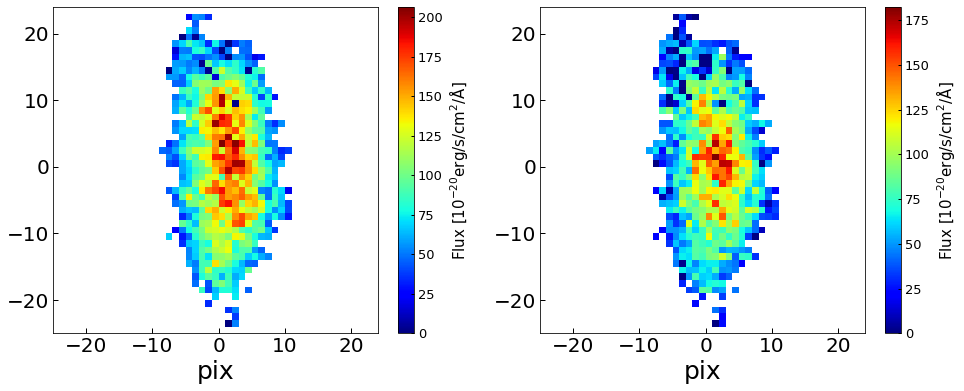

In [24]:
fig = plt.figure(figsize=(16, 6))
# cmap = plt.cm.get_cmap('sauron')

nx = (np.arange(50) - 50/2)/1.
ny = (np.arange(50) - 50/2)/1.
xpos, ypos = np.meshgrid(nx, ny, sparse=False, indexing='xy')

ax1 = fig.add_subplot(121)
flux_S2a_new = np.full_like(S2a_f,np.nan)
flux_S2a_new[region_selet] = S2a_f[region_selet]
ax1.tick_params(direction='in', labelsize = 20, length = 5, width=1.0)
ax1.set_xlabel('pix',fontsize=25)
ax1 = ax1.pcolormesh(ypos, xpos, flux_S2a_new, cmap=plt.cm.jet)
cb = plt.colorbar(ax1)
cb.ax.tick_params(direction='in', labelsize = 13, length = 3, width=1.0)
cb.set_label(r'${\rm Flux\ [10^{-20}erg/s/cm^2/\AA]}$',fontsize = 15)

ax2 = fig.add_subplot(122)
ax2.tick_params(direction='in', labelsize = 20, length = 5, width=1.0)
ax2.set_xlabel('pix',fontsize=25)
flux_S2b_new = np.full_like(S2b_f,np.nan)
flux_S2b_new[region_selet] = S2b_f[region_selet]
ax2 = ax2.pcolormesh(ypos, xpos, flux_S2b_new, cmap=plt.cm.jet)
cb = plt.colorbar(ax2)
cb.ax.tick_params(direction='in', labelsize = 13, length = 3, width=1.0)
cb.set_label(r'${\rm Flux\ [10^{-20}erg/s/cm^2/\AA]}$',fontsize = 15)

In [25]:
S2_R = S2a_f/S2b_f
S2_R_err = np.sqrt((S2a_ferr/S2b_f)**2 +
                   ((S2a_f*S2b_ferr)/S2b_f**2)**2)

fa = 627.1
fb = 2107
fc = 0.4315
Ne = (fa*S2_R-fc*fb)/(fc - S2_R)
Ne_err = np.sqrt((((fa*(fc - S2_R)+(fa*S2_R-fc*fb)) * S2_R_err) / (fc - S2_R) ** 2)**2)

76.9361930635837

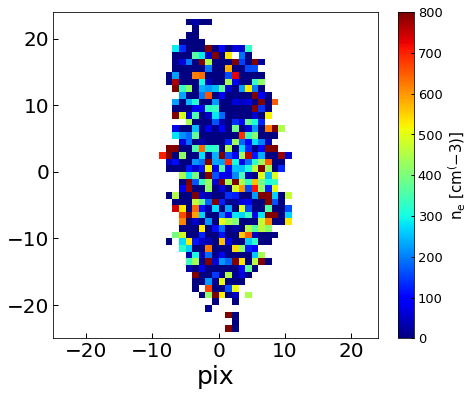

In [26]:
fig = plt.figure(figsize=(16, 6))
# cmap = plt.cm.get_cmap('sauron')

ax1 = fig.add_subplot(121)
ax1.tick_params(direction='in', labelsize = 20, length = 5, width=1.0)
ax1.set_xlabel('pix',fontsize=25)
Ne_new = np.full_like(Ne,np.nan)
Ne_new[region_selet] = Ne[region_selet]
Ne_err_new = np.full_like(Ne_err,np.nan)
Ne_err_new[region_selet] = Ne_err[region_selet]
ax1 = ax1.pcolormesh(ypos, xpos, Ne_new, cmap=plt.cm.jet,vmin = 0,vmax = 800)
cb = plt.colorbar(ax1)
cb.ax.tick_params(direction='in', labelsize = 13, length = 3, width=1.0)
cb.set_label(r'${\rm n_e \ [cm^(-3)]}$',fontsize = 15)

# ax2 = fig.add_subplot(122)
# ax2.tick_params(direction='in', labelsize = 20, length = 5, width=1.0)
# ax2.set_xlabel('pix',fontsize=25)
# Ne_err_new = np.full_like(Ne_err,np.nan)
# Ne_err_new[snr_cut] = Ne_err[snr_cut]
# ax2 = ax2.pcolormesh(ypos, xpos, Ne_err_new, cmap=cmap,vmax =600)
# cb = plt.colorbar(ax2)
# cb.ax.tick_params(direction='in', labelsize = 13, length = 3, width=1.0)
# cb.set_label(r'${\rm n_e_err \ [cm^(-3)]}$',fontsize = 15)
np.nanmedian(Ne_new)

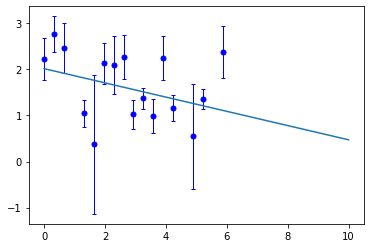

In [27]:
ne_maaxis = np.asarray([Ne_new[i,25] for i in range(50)])
neerr_maaxis= np.asarray([Ne_err_new[i,25] for i in range(50)])

ne_miaxis = np.asarray([Ne_new[25,i] for i in range(50)])
neerr_miaxis= np.asarray([Ne_err_new[25,i] for i in range(50)])
logne = np.log10(ne_miaxis)
logne_err = np.sqrt(neerr_miaxis/ne_miaxis)/np.log(10)
logne[np.isnan(logne)] = 0
logne_err[np.isnan(logne_err)] = 0
logne_r = 0.5*(logne[0:25][::-1]+logne[25:])
logne_r_serr = 0.5*np.sqrt(logne_err[0:25][::-1]**2+logne_err[25:]**2)
logne_r[logne_r==0] = np.nan
logne_r_serr[logne_r_serr==0] = np.nan
arc_pixel = 0.2
dist   = 335.8  
pix2kpc = (arc_pixel/2.06e5)*dist*1.0e3
major_r = np.arange(0,25,1)*pix2kpc
plt.errorbar(major_r,logne_r,yerr = logne_r_serr,fmt='bo:',elinewidth=1,ms=5,capsize=2,linestyle='None')

from scipy.optimize import curve_fit
def model(x,*p):
    model = p[0]*x + p[1]
    return model
p0 = np.array([-0.5,2])
p_bound = ([-1,0],[1,5])
yy = logne_r[~np.isnan(logne_r)] 
yy_err = logne_r_serr[~np.isnan(logne_r_serr)] 
popt,pcov = curve_fit(model,major_r[1:-8],yy,p0=p0,bounds=p_bound,sigma=yy_err)
fx = np.arange(0,10,0.0001)
fy = popt[0]*fx+popt[1]
plt.plot(fx,fy)

In [28]:
pcov

array([[ 0.0089369 , -0.02760768],
       [-0.02760768,  0.10394646]])

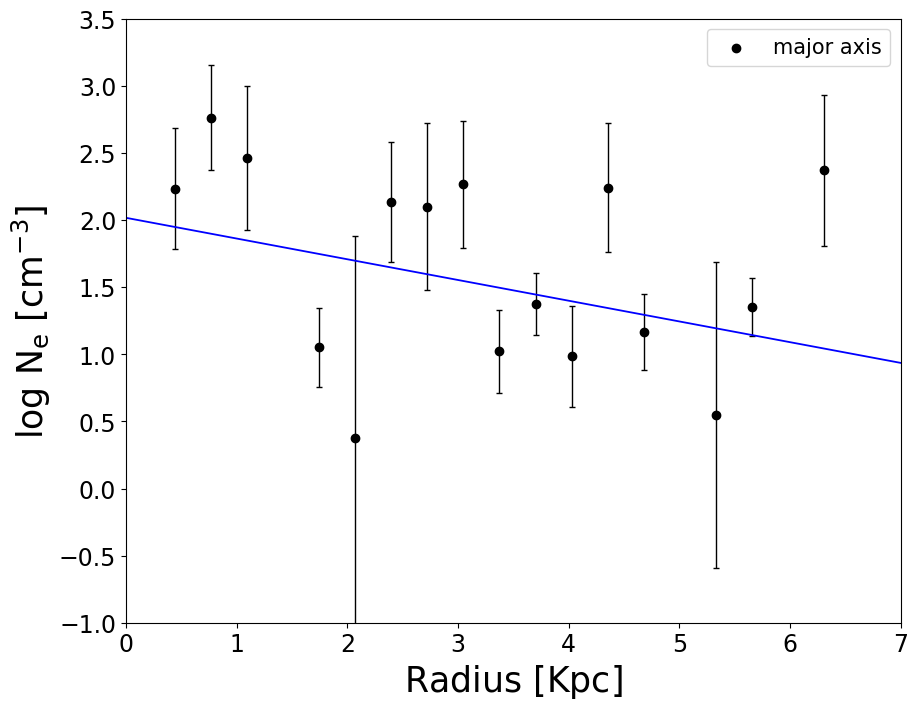

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=100)
ax.tick_params(axis='both', which='major', labelsize=17)
ax.tick_params(axis='both', which='minor', labelsize=17)
ax.set_xlabel(r"${\rm  Radius\ [Kpc]}$", fontsize=25)
ax.set_ylabel(r"${\rm log\ N_{e}\ [cm^{-3}]}$", fontsize=25)

ax.errorbar(major_r+0.44,logne_r,yerr = logne_r_serr,fmt='ko:',elinewidth=1,ms=5,capsize=2,linestyle='None')
ax.scatter(major_r+0.44,logne_r,label='major axis',color = 'k')
fx = np.arange(0,10,0.0001)
fy = -0.15448187 * fx + 2.01691284
ax.plot(fx,fy,'b', alpha=1,lw=1.3)
ax.set_xlim(0, 7)
ax.set_ylim(-1, 3.5)
plt.legend(fontsize=15.0, markerscale=1)
plt.savefig('N_e_R.pdf',dpi = 600, bbox_inches='tight')

In [33]:
rdd=Table({'Radius':major_r+0.44,
           'log_Ne':logne_r,
           'log_Ne_err':logne_r_serr,})
ascii.write(rdd,'data/log_ne_major_axis.txt',overwrite=1)

In [704]:
out_xx = []
out_yy = []
for y in np.arange(50):
    for x in np.arange(50):
        nan_p = np.isnan(flux_OIII_broad[y,x])
        if nan_p:
            pass
        else:
            out_xx.append(x)
            out_yy.append(y)
            
outflow_ne = []
outflow_ne_err = []
for i in np.arange(len(out_xx)):
    outflow_ne.append(Ne_new[out_xx[i],out_yy[i]])
    outflow_ne_err.append(Ne_err_new[out_xx[i],out_yy[i]])
    
            
outflow_ne     = np.log10(np.array(outflow_ne))
outflow_ne_err = np.sqrt((np.array(outflow_ne_err)/outflow_ne)**2)/np.log(10)

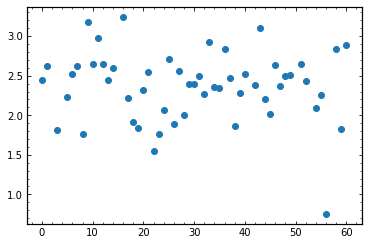

In [709]:
test_xx = np.arange(len(outflow_ne))
plt.plot(test_xx,outflow_ne,marker='o',linestyle='None')
# plt.errorbar(test_xx,outflow_ne,yerr = outflow_ne_err ,marker='o',linestyle='None')

In [711]:
np.nanmedian(outflow_ne),np.nanstd(outflow_ne)

(2.4144884491259164, 0.436796186698664)

In [739]:
O3_Sig = fits.open("SDSSJ0228_O3_5007_sigma.fits")

O3n_sigma     = O3_Sig[1].data/5006.8 * 3*10**5
O3n_sigma_err = O3_Sig[2].data/5006.8 * 3*10**5
O3b_sigma     = O3_Sig[3].data/5006.8 * 3*10**5
O3b_sigma_err = O3_Sig[4].data/5006.8 * 3*10**5
sigma_corr = 3*10**5/2988.96822493805/2.35

O3n_sigma_corr = np.sqrt(O3n_sigma**2 - sigma_corr**2)
O3b_sigma_corr = np.sqrt(O3b_sigma**2 - sigma_corr**2)
v_O3_data = ascii.read('analyse_data_image/SDSSJ0228/OIII_outflow_velocity.txt')
v50_O3 = v_O3_data['v50_O3_broad']
v50_O3_err = v_O3_data['v50_O3_broad_error']

In [781]:
### define units

kms = u.km / u.s
msunyr = u.M_sun / u.yr
g_cm3 = u.g / u.cm**3
ergs = u.erg /u.s


In [819]:
L_O3 = 40.293484922623755+0.394          # log erg/s
L_AGN = L_O3 + np.log10(142)             # log erg/s
SFR_tol = 1.516461233036317              # Msun/yr
c = 299792.458 *kms  
L_sun = ((3.83*10**26)*u.W).to(ergs)

V_lc = np.nanmedian(v50_O3) * kms
sigam_lc = np.nanmedian(O3b_sigma_corr) * kms

Ne_wing = 10**np.nanmedian(outflow_ne) * g_cm3
F_O3_wing = np.nansum(flux_OIII_broad*10**(-20))
dist = 335.8 * 3.0856776 * 10**(24)                         ## cm
L_O3_wing = 4*np.pi*dist**2*F_O3_wing * ergs

M_O3 = ((L_O3_wing/(10**43*ergs))*(Ne_wing/(100*g_cm3))*4*10**7) * u.M_sun          # Msun
V_out = np.sqrt(V_lc**2+sigam_lc**2)
R_out = (2.64-0.19) * u.kpc  
dM_O3 = (3*M_O3*V_out/R_out).to(msunyr)               # M_sun/yr
dE_O3 = (0.5* dM_O3*(V_lc**2+3*sigam_lc**2)).cgs
cdP_O3 = (dM_O3*V_out*c).to(ergs)


In [825]:
np.log10(cdP_O3.value) - L_AGN

-1.2213104060731652

In [838]:
dM_O3

<Quantity 0.01046647 solMass / yr>

In [839]:
L_AGN

42.83977326700681